In [1]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn
import zipfile

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
ExpMat = pd.read_csv("dat/Jon_data/energy-exp_level.csv", index_col="ROW")
ExpMat2, ExpZscoreMat2, ExpMatNorm2, ExpZscoreMatNorm2 = LoadExpressionMatrices(
                        ExpMat = "../dat/allen-mouse-exp/new-energy-conn-model.csv", 
                        ExpZscoreMat = "../dat/allen-mouse-exp/new-energy-conn-zscore.csv",
                        ExpMatNorm = "../dat/allen-mouse-exp/energy-neuronorm.csv",
                        ExpZscoreMatNorm = "../dat/allen-mouse-exp/energy-zscore-neuronorm.csv")
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")
str2reg = STR2Region()

In [2]:
ExpZ2Mat = pd.read_csv("dat/ExpMat/Energy.ExpZ2.csv", index_col=0)

In [3]:
# Load Mutations
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")

In [4]:
ASD_Rep_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Rep_Trios.txt", delimiter="\t")

In [5]:
ASD_Rep_Trios.head(2)

,FamID,IID,Sex,Pheno
0,SF0000903,SP0000903,Female,Affected
1,SF0001390,SP0001390,Male,Affected


In [6]:
xx = ASD_Rep_Trios[ASD_Rep_Trios["Pheno"]=="Unaffected"]

In [7]:
xx.shape

(2499, 4)

In [8]:
xx2 = ASD_Discov_Trios[ASD_Discov_Trios["Pheno"]=="Unaffected"]
xx2.shape

(5768, 7)

In [9]:
5768 + 2499

8267

# FSIQ

In [10]:
IQ_dat = pd.read_excel("../doc/1-s2.0-S0092867419313984-mmc4.xlsx", sheet_name="Phenotype")
IQ_dat = IQ_dat.dropna(subset=['IQ'])

/Users/jiayao/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [11]:
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")

In [12]:
HighIQ = IQ_dat[IQ_dat["IQ"]>70]["Phenotype_ID"].values
LowIQ = IQ_dat[IQ_dat["IQ"]<=70]["Phenotype_ID"].values
print(len(HighIQ), len(LowIQ))

3292 1572


<AxesSubplot:>

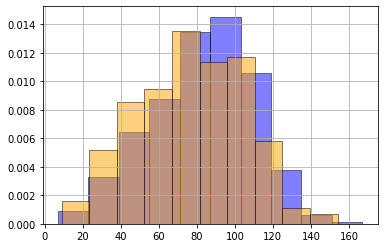

In [13]:
IQ_dat[IQ_dat["Sex"]=="Male"]["IQ"].hist(color="blue", density=1, alpha=0.5, edgecolor='black')
IQ_dat[IQ_dat["Sex"]=="Female"]["IQ"].hist(color="orange", density=1, alpha=0.5, edgecolor='black')

In [14]:
HighIQ = IQ_dat[(IQ_dat["IQ"]>70)]
LowIQ = IQ_dat[(IQ_dat["IQ"]<=70)]
MaleIQ = IQ_dat[IQ_dat["Sex"]=="Male"]
FemaleIQ = IQ_dat[IQ_dat["Sex"]=="Female"]
HighIQ_male = IQ_dat[(IQ_dat["IQ"]>70) & (IQ_dat["Sex"]=="Male")]
HighIQ_female = IQ_dat[(IQ_dat["IQ"]>70) & (IQ_dat["Sex"]=="Female")]
LowIQ_male = IQ_dat[(IQ_dat["IQ"]<=70) & (IQ_dat["Sex"]=="Male")]
LowIQ_female = IQ_dat[(IQ_dat["IQ"]<=70) & (IQ_dat["Sex"]=="Female")]

In [15]:
# Select HC genes
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
#Spark_Meta = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1e-3]
HighConfGenes = Spark_Meta_HC["HGNC"].values
HighConfMuts = ASD_Discov_Muts[ASD_Discov_Muts["HGNC"].isin(HighConfGenes)]
#HighConfMuts = ASD_Discov_Muts
HighConfMuts = Filt_LGD_Mis(HighConfMuts, Dmis=True)
#HighConfMuts = HighConfMuts[HighConfMuts["GeneEff"]!="missense"]

In [16]:
HIQ_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighIQ["Phenotype_ID"].values)]
LIQ_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowIQ["Phenotype_ID"].values)]

M_Muts = HighConfMuts[HighConfMuts["IID"].isin(MaleIQ["Phenotype_ID"].values)]
F_Muts = HighConfMuts[HighConfMuts["IID"].isin(FemaleIQ["Phenotype_ID"].values)]

HIQ_M_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighIQ_male["Phenotype_ID"].values)]
HIQ_F_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighIQ_female["Phenotype_ID"].values)]
LIQ_M_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowIQ_male["Phenotype_ID"].values)]
LIQ_F_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowIQ_female["Phenotype_ID"].values)]
print("HIQ_M: %d HIQ_F: %d LIQ_M: %d LIQ_F: %d"%
      (HIQ_M_Muts.shape[0], HIQ_F_Muts.shape[0], LIQ_M_Muts.shape[0], LIQ_F_Muts.shape[0]))

HIQ_M: 75 HIQ_F: 12 LIQ_M: 67 LIQ_F: 42


In [17]:
HIQ_Muts.to_csv("dat/Spark.ES.HIQ.muts.csv", index=False)
LIQ_Muts.to_csv("dat/Spark.ES.LIQ.muts.csv", index=False)

### Paired test on cortex vs. subcortex

In [18]:
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_ExomeWide = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
print("Spark Meta", Spark_Meta_ExomeWide.shape)

Spark Meta (61, 67)


In [19]:
Spark_Meta_ExomeWide.head(2)

,GeneID,EntrezID,HGNC,CytoBand,ExACpLI,LoFOvsE,LOEUF,LOEUFbin,SynOvsE,sHet,...,AllExpected_NDD,pAllEnrich_NDD,MisObserved_NDD,MisExpected_NDD,pMisEnrich_NDD,MisEvents_NDD,MisDist_NDD,pMisCluster_NDD,pMisComb_NDD,pDenovoWEST_NDD
0,ENSG00000143442,23126,POGZ,1q21.3,1,0.045859,0.119,0,0.97057,0.214955,...,0.934605,0.0,2.44,0.601588,0.00168,9,550.2,0.03,0.000571,0.0
1,ENSG00000169057,4204,MECP2,Xq28,0.69809,0.085755,0.407,1,2.02820,0.088203,...,0.18052,0.0,9.24,0.124697,0.0,44,131.4,0.0,0.0,0.0


In [20]:
Spark_Meta_Genes = Spark_Meta_ExomeWide["EntrezID"].values
IndvZ2 = pd.read_csv("dat/ExpMat/Energy.ExpZ2.csv", index_col=0)
Spark_Meta_Genes = np.array([x for x in Spark_Meta_Genes if x in IndvZ2.index.values])
Spark_Meta_IndvZ2 = IndvZ2.loc[Spark_Meta_Genes, :]

In [21]:
IndvZ2 = Spark_Meta_IndvZ2
Circuit_STRs = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.csv").head(50)["STR"].values
len(Circuit_STRs)

50

In [22]:
# make Group_Dictionary
REG2STRs = {}
Iso_Sub = {"Isocortex":[], "Subcortex":[]}
for STR in Circuit_STRs:
    reg = str2reg[STR]
    if reg not in REG2STRs:
        REG2STRs[reg] = []
    REG2STRs[reg].append(STR)
    if reg == "Isocortex":
        Iso_Sub["Isocortex"].append(STR)
    else:
        Iso_Sub["Subcortex"].append(STR)

HIQ
Cortex 0.144	Subcortex: 0.330	WilcoxonP=6.337e-03

LIQ
Cortex 0.447	Subcortex: 0.434	WilcoxonP=8.823e-01

Male
Cortex 0.331	Subcortex: 0.416	WilcoxonP=1.229e-01

Female
Cortex 0.285	Subcortex: 0.326	WilcoxonP=5.152e-01

HIQ_Male
Cortex 0.183	Subcortex: 0.338	WilcoxonP=4.381e-02

HIQ_Female
Cortex -0.092	Subcortex: 0.284	WilcoxonP=1.855e-02

LIQ_Male
Cortex 0.491	Subcortex: 0.500	WilcoxonP=9.284e-01

LIQ_Female
Cortex 0.384	Subcortex: 0.337	WilcoxonP=6.661e-01



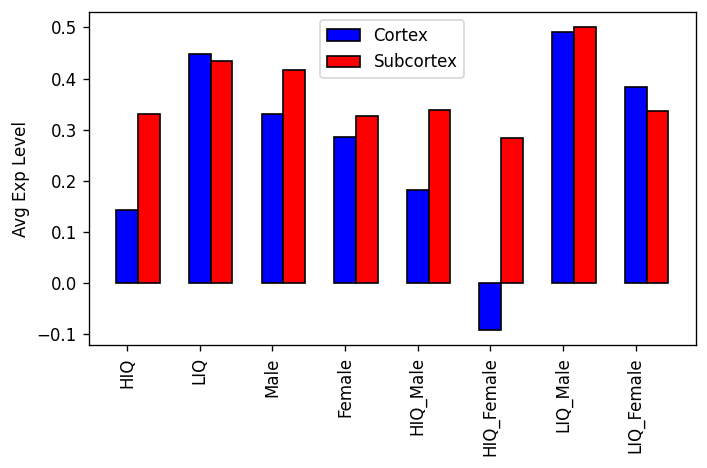

In [23]:
fig, ax = plt.subplots(dpi=120)
pos = 0
barWidth = 0.3
Cortex_dat = []
Subcortex_dat = []
for cohort, DF in zip(["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"], 
        [HIQ_Muts, LIQ_Muts, M_Muts, F_Muts, HIQ_M_Muts, HIQ_F_Muts, LIQ_M_Muts, LIQ_F_Muts]):
    X, Y = [], []
    for i, mut in DF.iterrows():
        try:
            x = IndvZ2.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Isocortex"])].values
            y = IndvZ2.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Subcortex"])].values
            x = np.mean([_ for _ in x if _==_])
            y = np.mean([_ for _ in y if _==_])
            X.append(x)
            Y.append(y)
        except:
            continue
    print(cohort)
    stat, p = scipy.stats.wilcoxon(X,Y)
    print("Cortex %.3f\tSubcortex: %.3f\tWilcoxonP=%.3e"%(np.mean(X), np.mean(Y), p))
    print()
    Cortex_dat.append(np.mean(X))
    Subcortex_dat.append(np.mean(Y))
    pos += 1
r1 = np.arange(pos)
r2 = [x + barWidth for x in r1]
plt.bar(r1, Cortex_dat, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Cortex')
plt.bar(r2, Subcortex_dat, width = barWidth, color = 'red', edgecolor = 'black', capsize=7, label='Subcortex')  
plt.xticks(list(range(pos)), 
           ["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"],
          rotation=90)
plt.ylabel('Avg Exp Level')
plt.legend()
plt.tight_layout()

#### ExpLevel

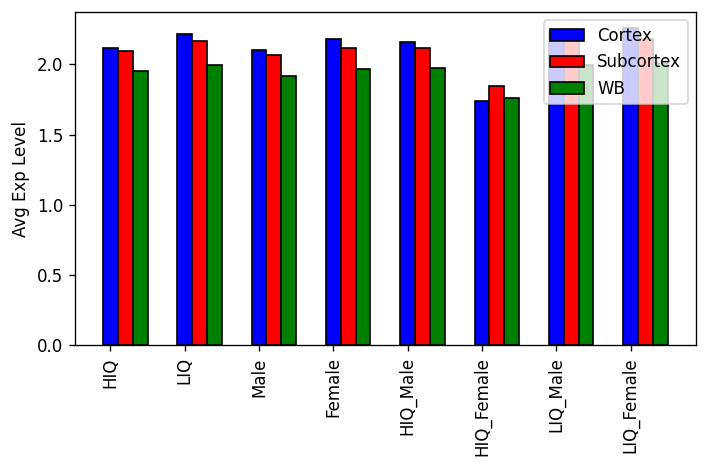

In [24]:
fig, ax = plt.subplots(dpi=120)
pos = 0
barWidth = 0.2
Cortex_dat = []
Subcortex_dat = []
WholeBrain_dat = []
for cohort, DF in zip(["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"], 
        [HIQ_Muts, LIQ_Muts, M_Muts, F_Muts, HIQ_M_Muts, HIQ_F_Muts, LIQ_M_Muts, LIQ_F_Muts]):
    X, Y, Z = [], [], []
    gene_already_showed = set([])
    for i, mut in DF.iterrows():
        try:
            if GeneSymbol2Entrez[mut["HGNC"]] in gene_already_showed:
                continue
            x = ExpMat.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Isocortex"])].values
            y = ExpMat.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Subcortex"])].values
            z = ExpMat.loc[GeneSymbol2Entrez[mut["HGNC"]], :].values
            x = np.mean([_ for _ in x if _==_])
            y = np.mean([_ for _ in y if _==_])
            z = np.mean([_ for _ in z if _==_])
            X.append(x)
            Y.append(y)
            Z.append(z)
            gene_already_showed.add(GeneSymbol2Entrez[mut["HGNC"]])
        except:
            continue
    #print(cohort)
    stat, p = scipy.stats.wilcoxon(X,Y)
    #print("Cortex %.3f\tSubcortex: %.3f\tWilcoxonP=%.3e"%(np.mean(X), np.mean(Y), p))
    #plt.bar(pos-barWidth, np.mean(X), width=barWidth, color="blue", label="Cortex")
    #plt.bar(pos, np.mean(Y), width=barWidth, color="orange", label="Subcortex")
    Cortex_dat.append(np.mean(X))
    Subcortex_dat.append(np.mean(Y))
    WholeBrain_dat.append(np.mean(Z))
    pos += 1
    #print()
r1 = np.arange(pos)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
plt.bar(r1, Cortex_dat, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Cortex')
plt.bar(r2, Subcortex_dat, width = barWidth, color = 'red', edgecolor = 'black', capsize=7, label='Subcortex')  
plt.bar(r3, WholeBrain_dat, width = barWidth, color = 'green', edgecolor = 'black', capsize=7, label='WB')  
plt.xticks(list(range(pos)), 
           ["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"],
          rotation=90)
plt.ylabel('Avg Exp Level')
plt.legend()
plt.tight_layout()
plt.savefig("figs/IQ_Sex_ExpLevel.gene.pdf")

In [25]:
WholeBrain_dat

[1.952809457995108,
 1.994912115764701,
 1.9135065211153688,
 1.9628649241805332,
 1.9738217794669841,
 1.759299723453725,
 1.9908878791085574,
 2.0119607225544582]

(array([1572122.,  467007.,  313979.,  254840.,  218244.,  185358.,
         146492.,   93681.,   42355.,    6945.]),
 array([1.53646965e-04, 5.32952574e-01, 1.06575150e+00, 1.59855043e+00,
        2.13134936e+00, 2.66414828e+00, 3.19694721e+00, 3.72974614e+00,
        4.26254506e+00, 4.79534399e+00, 5.32814292e+00]),
 <BarContainer object of 10 artists>)

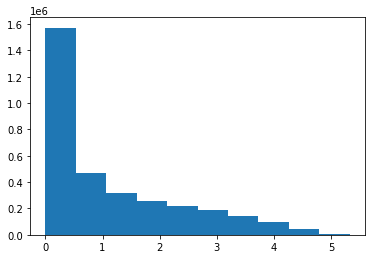

In [26]:
plt.hist(ExpMat.values.flatten())

###  Bias on sub-population

In [27]:
#Agg_Match = pd.read_csv("dat/Final_Spark_Meta.Matches.csv", index_col="GENE")

In [28]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn
def Mut2GeneDF(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        #pLI = float(row["ExACpLI"])
        #pLI = MutDF[MutDF["HGNC"]]
        Muts = MutDF[MutDF["HGNC"]==g]
        pLI = float(Muts["ExACpLI"].values[0])
        #print(pLI)
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        if pLI > 0.05:
            gene2MutN[Entrez] = N_LGD * 0.554 + N_Dmis * 0.333
        else:
            gene2MutN[Entrez] = N_LGD * 0.138 + N_Dmis * 0.130
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [29]:
HIQ_GW = Mut2GeneDF(HIQ_Muts, 0.347, 0.194) # Not use weights input
HIQ_Spec = AvgSTRZ_Weighted(IndvZ2, HIQ_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.HIQ_spec.bias.csv")

LIQ_GW = Mut2GeneDF(LIQ_Muts, 0.347, 0.194)
LIQ_Spec = AvgSTRZ_Weighted(IndvZ2, LIQ_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.LIQ_spec.bias.csv")


In [30]:

Male_GW = Mut2GeneDF(M_Muts, 0.347, 0.194)
Male_Spec = AvgSTRZ_Weighted(IndvZ2, Male_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.Male_spec.bias.csv")

Female_GW = Mut2GeneDF(F_Muts, 0.347, 0.194)
Female_Spec = AvgSTRZ_Weighted(IndvZ2, Female_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.Female_spec.bias.csv")

In [31]:
HIQ_M_GW = Mut2GeneDF(HIQ_M_Muts, 0.347, 0.194)
HIQ_M_Spec = AvgSTRZ_Weighted(IndvZ2, HIQ_M_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.HIQ_M_spec.bias.csv")

HIQ_F_GW = Mut2GeneDF(HIQ_F_Muts, 0.347, 0.194)
HIQ_F_Spec = AvgSTRZ_Weighted(IndvZ2, HIQ_F_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.HIQ_F_spec.bias.csv")

LIQ_M_GW = Mut2GeneDF(LIQ_M_Muts, 0.347, 0.194)
LIQ_M_Spec = AvgSTRZ_Weighted(IndvZ2, LIQ_M_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.LIQ_M_spec.bias.csv")

LIQ_F_GW = Mut2GeneDF(LIQ_F_Muts, 0.347, 0.194)
LIQ_F_Spec = AvgSTRZ_Weighted(IndvZ2, LIQ_F_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.LIQ_F_spec.bias.csv")

In [32]:
HIQ_Spec = HIQ_Spec.set_index("STR")
LIQ_Spec = LIQ_Spec.set_index("STR")
Male_Spec = Male_Spec.set_index("STR")
Female_Spec = Female_Spec.set_index("STR")

HIQ_M_Spec = HIQ_M_Spec.set_index("STR")
HIQ_F_Spec = HIQ_F_Spec.set_index("STR")
LIQ_M_Spec = LIQ_M_Spec.set_index("STR")
LIQ_F_Spec = LIQ_F_Spec.set_index("STR")

In [33]:
#Circuit_STRs = pd.read_csv("dat/Circuit_GN_42.csv")["STR"].values
Circuit_STRs = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.csv").head(50)["STR"].values
len(Circuit_STRs)

50

In [34]:
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
     'Olfactory_areas']
Isocortex = ["Isocortex"]
Subcortex = ['Hippocampus', 'Cortical_subplate', 
     'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum', 'Olfactory_areas']

In [35]:
REG_Layer1 = {}
REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
REG_Layer2["Cortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
REG_Layer2["Subcortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in REG_Layer1:
        REG_Layer1[REG] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
    REG_Layer1[REG]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    REG_Layer2[Broder]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])
        

In [36]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("figs/PhenotypeBias.pdf")

In [37]:
data = []
for group in ["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(REG_Layer2[Broder][group]))
    data.append(tmp)
data = np.array(data)
data = data.transpose()

In [38]:
data.shape

(2, 4)

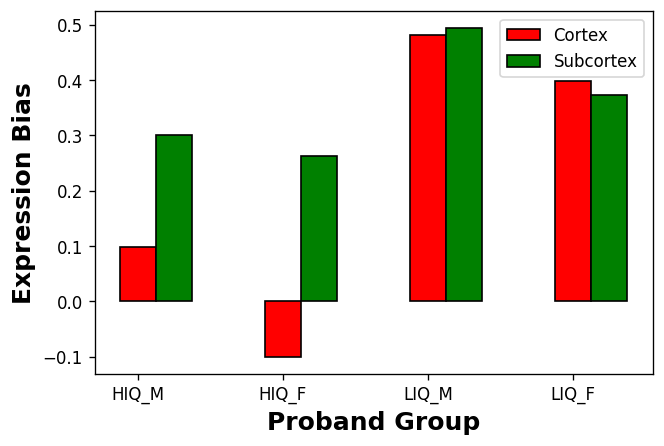

In [39]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(4)
ax.bar(X + 0.00, data[0], color='red', width=0.25, label="Cortex", edgecolor ='black')
ax.bar(X + 0.25, data[1], color='green', width=0.25, label="Subcortex", edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, ['HIQ_M', 'HIQ_F', 'LIQ_M', 'LIQ_F'])
 
plt.legend()
pdf.savefig( fig )

In [40]:
# All Regions
Circuit_STRs = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.csv").head(50)["STR"].values
len(Circuit_STRs)
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
     'Olfactory_areas']
Isocortex = ["Isocortex"]
Subcortex = ['Hippocampus', 'Cortical_subplate', 
     'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum', 'Olfactory_areas']

In [41]:
Cortex_CirSTRs = []
Subcor_CirSTRs = []
for _str in Circuit_STRs:
    if str2reg[_str] in Isocortex:
        Cortex_CirSTRs.append(_str)
    else:
        Subcor_CirSTRs.append(_str)

In [42]:
REG_Layer1 = {}
REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
REG_Layer2["Cortex"] = {"HIQ":[], "LIQ":[]}
REG_Layer2["Subcortex"] = {"HIQ":[], "LIQ":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in REG_Layer1:
        REG_Layer1[REG] = {"HIQ":[], "LIQ":[]}
    REG_Layer1[REG]['HIQ'].append(HIQ_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ'].append(LIQ_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    REG_Layer2[Broder]['HIQ'].append(HIQ_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ'].append(LIQ_Spec.loc[STR, "EFFECT"])

In [43]:
data = []
for group in ["HIQ", "LIQ"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(REG_Layer2[Broder][group]))
    data.append(tmp)
data = np.array(data)
data = data.transpose()

In [44]:
data = [[np.mean(REG_Layer2["Cortex"]['HIQ']), 
             np.mean(REG_Layer2["Cortex"]['LIQ'])],
            [np.mean(REG_Layer2["Subcortex"]['HIQ']), 
             np.mean(REG_Layer2["Subcortex"]['LIQ'])]]

In [45]:
HIQ_DFs = []
with zipfile.ZipFile("dat/BootStrapMuts/asd.boot.HIQ.zip") as myzip:
    #print (myzip.namelist())
    for i in range(1,1001,1):
        fid = myzip.open('asd.boot.HIQ/{}.csv'.format(i), 'r')
        df = pd.read_csv(fid, index_col="STR")
        HIQ_DFs.append(df)
LIQ_DFs = []
with zipfile.ZipFile("dat/BootStrapMuts/asd.boot.LIQ.zip") as myzip:
    #print (myzip.namelist())
    for i in range(1,1001,1):
        fid = myzip.open('asd.boot.LIQ/{}.csv'.format(i), 'r')
        df = pd.read_csv(fid, index_col="STR")
        LIQ_DFs.append(df)

In [46]:
def GetBiasDat(DF, STRs):
    biases = DF.loc[STRs, "EFFECT"].values
    return np.mean(biases)
def GetBootsDist(DFs, STRs):
    dat = []
    for df in DFs:
        tmp = []
        biases = df.loc[STRs, "EFFECT"].values
        dat.append(np.mean(biases))
    return np.array(dat)

In [47]:
HIQ_Cortex_boots = GetBootsDist(HIQ_DFs, Cortex_CirSTRs)
HIQ_Subcor_boots = GetBootsDist(HIQ_DFs, Subcor_CirSTRs)
LIQ_Cortex_boots = GetBootsDist(LIQ_DFs, Cortex_CirSTRs)
LIQ_Subcor_boots = GetBootsDist(LIQ_DFs, Subcor_CirSTRs)

In [48]:
error1 = [np.std(HIQ_Cortex_boots), np.std(LIQ_Cortex_boots)]
error2 = [np.std(HIQ_Subcor_boots), np.std(LIQ_Subcor_boots)]

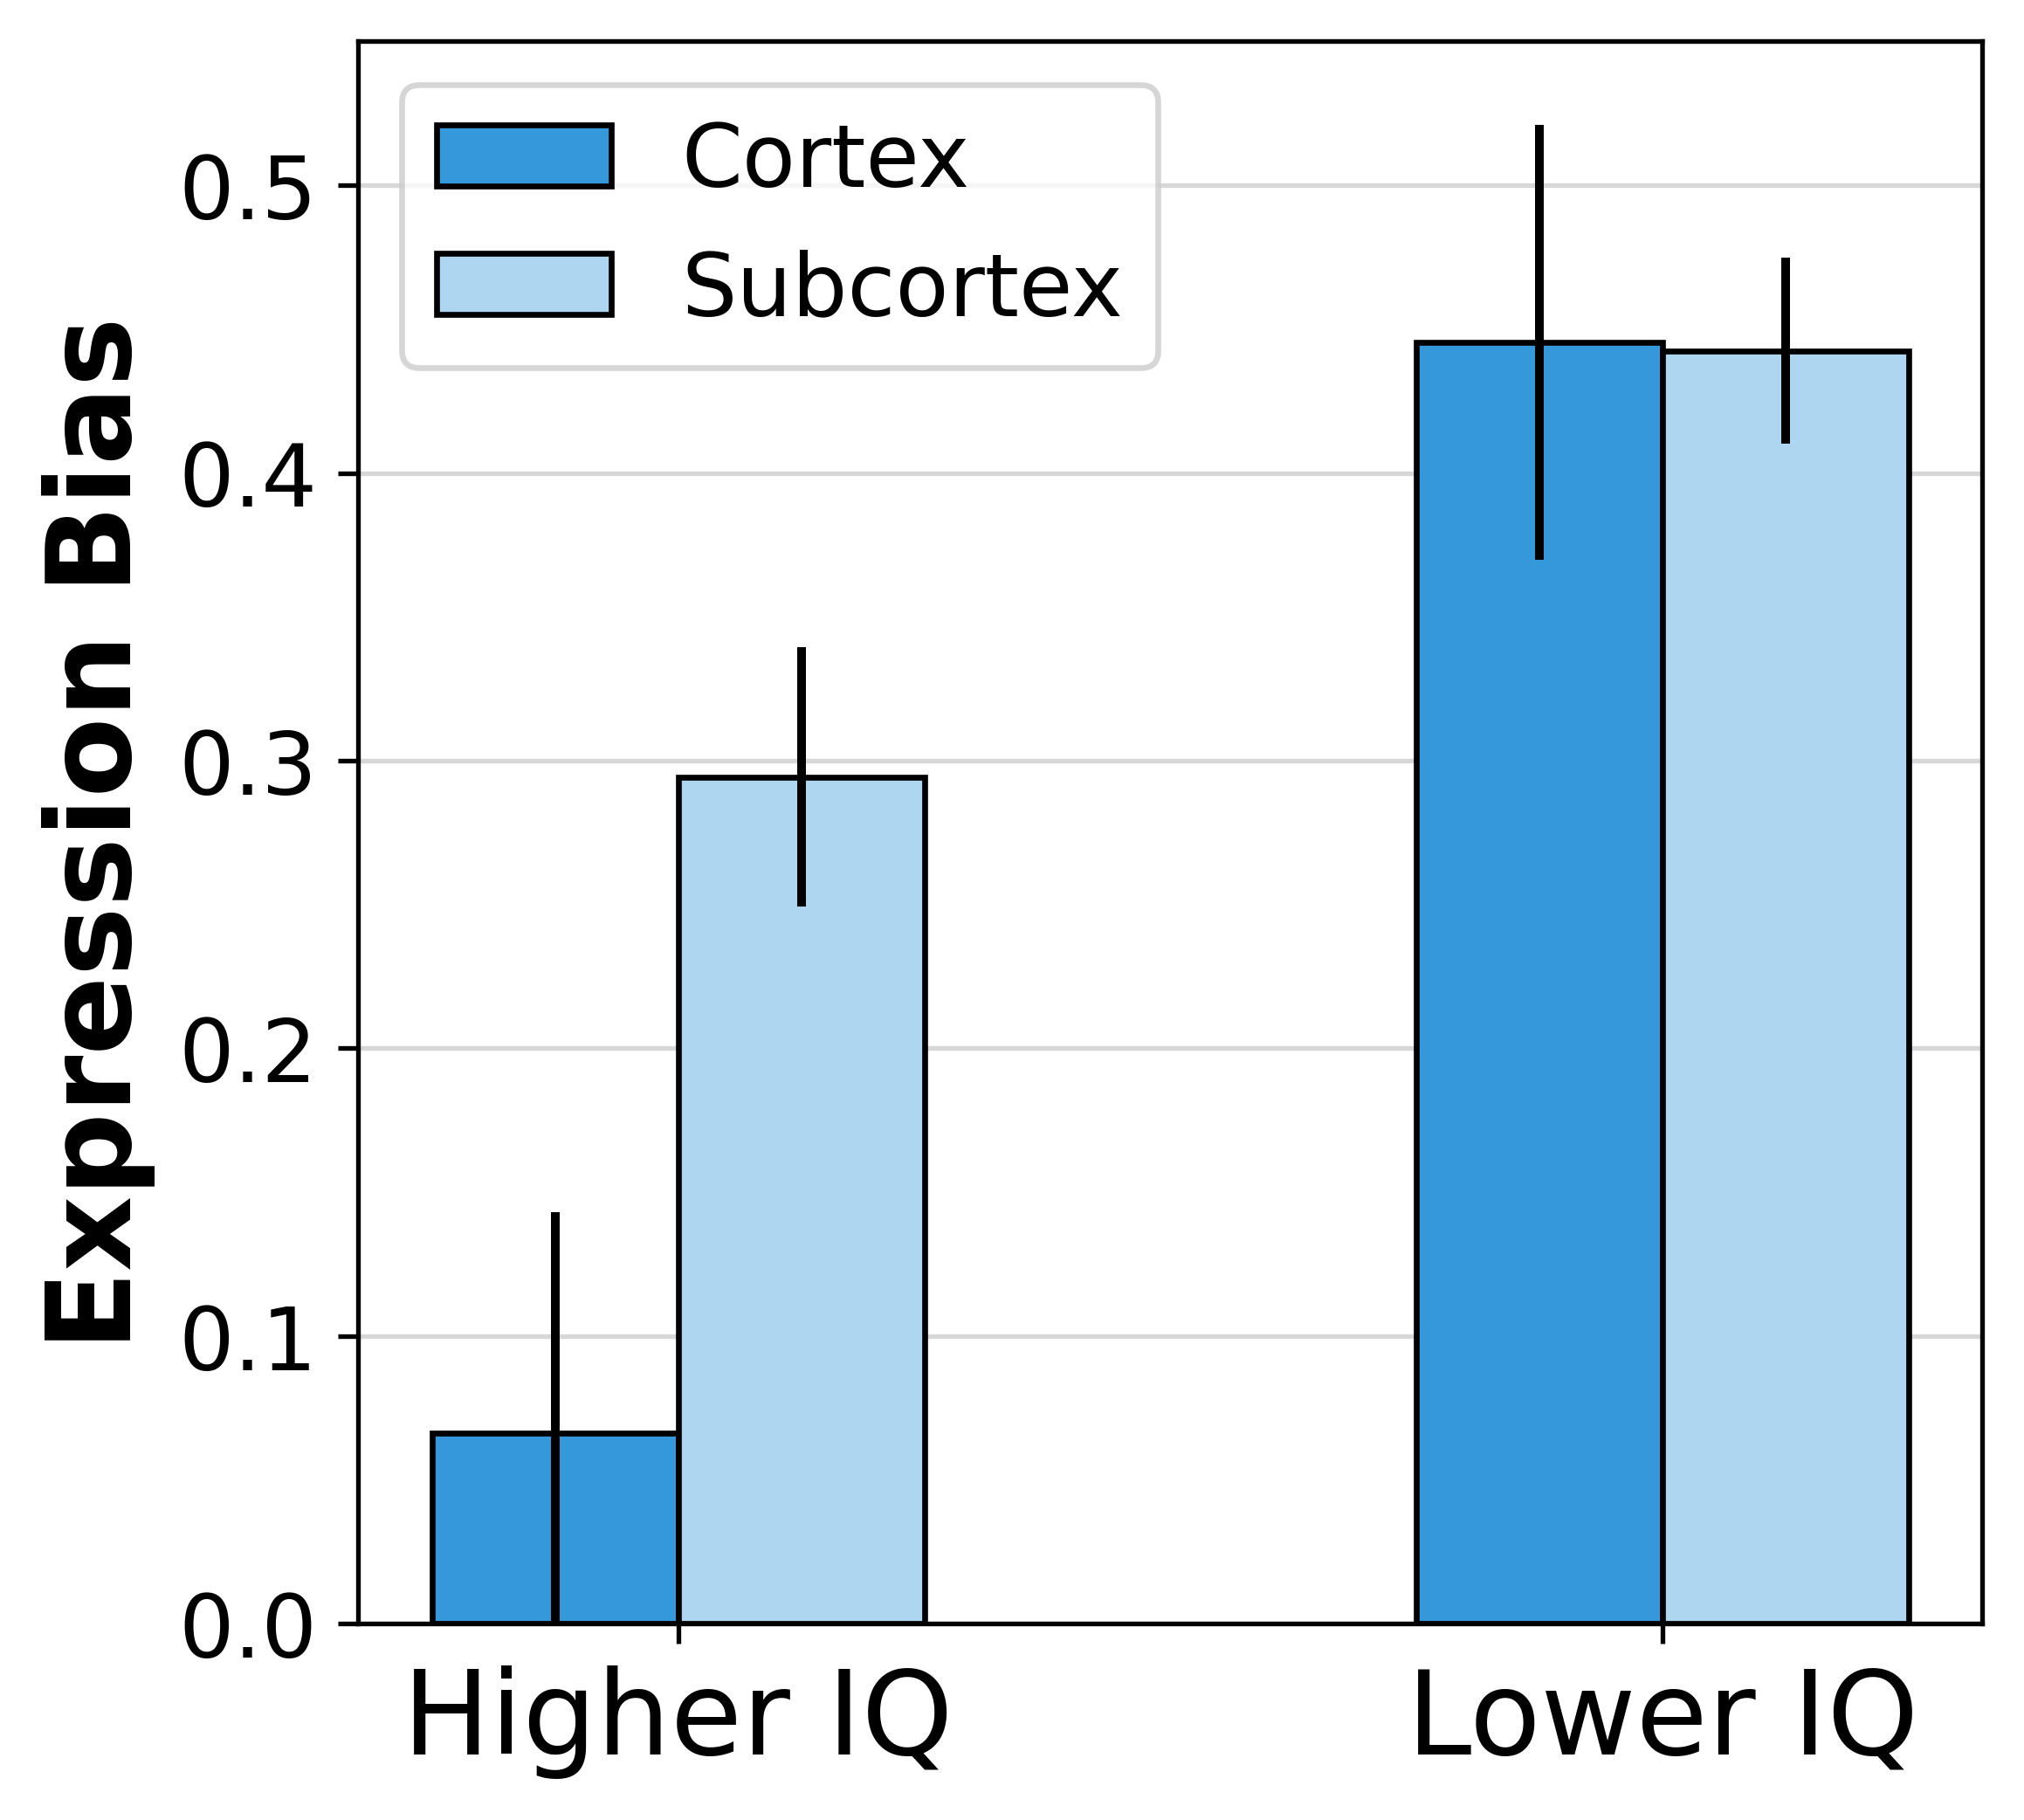

In [139]:
fig, ax = plt.subplots(dpi=480, figsize=(5,5))
X = np.arange(2)
ax.bar(X - 0.125, data[0], yerr=error1, color='#3498DB', width=0.25, label="Cortex", edgecolor ='black',
      hatch="")
ax.bar(X + 0.125, data[1], yerr=error2, color='#AED6F1', width=0.25, label="Subcortex", edgecolor ='black',
      hatch="")

props = {'connectionstyle':'bar','arrowstyle':'-',\
             'shrinkA':20,'shrinkB':20,'linewidth':2}

"""
lx = 0 -0.125
rx = 0.25-0.125
y=0.35
barh=0.01
barx = [lx, lx, rx, rx]
bary = [y, y+barh, y+barh, y]
mid = ((lx+rx)/2, y+barh)
ax.plot(barx, bary, c='black')
ax.annotate("p=6.3e-03", xy=(0, 0.37), zorder=5)

lx = 1-0.125
rx = 1.25-0.125
y=0.55
barh=0.01
barx = [lx, lx, rx, rx]
bary = [y, y+barh, y+barh, y]
mid = ((lx+rx)/2, y+barh)
ax.plot(barx, bary, c='black')
ax.annotate("p=0.88", xy=(1.05, 0.570), zorder=6)
"""

plt.xlabel('', fontweight ='bold', fontsize = 20)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 20)
plt.xticks(X, ['Higher IQ', 'Lower IQ'], fontsize=20)
plt.yticks(fontsize=15)
ax.set_ylim(0,0.55)
plt.legend(loc="upper left", fontsize=15)
ax.grid(True, axis="y", alpha=0.5)
ax.set_axisbelow(True)

In [56]:
data2 = []
for group in ["HIQ", "LIQ"]:
    tmp = []
    for Narrow in CIR_REGIONS:
        tmp.append(np.median(REG_Layer1[Narrow][group]))
    data2.append(tmp)
data2 = np.array(data2)
#data2 = data.transpose()
color_map = {"HIQ":"blue", 
             "LIQ":"red"}

In [57]:
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Olfactory_areas']

In [58]:
CIR_REGIONS_Dict = {}
for i in range(len(CIR_REGIONS)):
    CIR_REGIONS_Dict[CIR_REGIONS[i]] = []
for _str in Circuit_STRs:
    for i in range(len(CIR_REGIONS)):
        if str2reg[_str] == CIR_REGIONS[i]:
            CIR_REGIONS_Dict[CIR_REGIONS[i]].append(_str)
            break

In [59]:
CIR_REGIONS_Dict

{'Isocortex': ['Orbital_area_lateral_part',
  'Prelimbic_area',
  'Orbital_area_ventrolateral_part',
  'Infralimbic_area',
  'Primary_somatosensory_area_lower_limb',
  'Anteromedial_visual_area',
  'Agranular_insular_area_posterior_part',
  'Visceral_area',
  'Retrosplenial_area_lateral_agranular_part',
  'Primary_motor_area',
  'Primary_visual_area',
  'Anterior_cingulate_area_dorsal_part',
  'Secondary_motor_area',
  'Gustatory_areas',
  'Lateral_visual_area',
  'Agranular_insular_area_ventral_part',
  'Orbital_area_medial_part'],
 'Hippocampus': ['Dentate_gyrus',
  'Field_CA3',
  'Subiculum_ventral_part',
  'Field_CA1',
  'Field_CA2',
  'Parasubiculum'],
 'Cortical_subplate': ['Endopiriform_nucleus_dorsal_part',
  'Claustrum',
  'Endopiriform_nucleus_ventral_part'],
 'Amygdalar': ['Lateral_amygdalar_nucleus',
  'Basomedial_amygdalar_nucleus',
  'Intercalated_amygdalar_nucleus',
  'Central_amygdalar_nucleus',
  'Basolateral_amygdalar_nucleus'],
 'Striatum': ['Nucleus_accumbens',
  'L

In [76]:
HighIQ_dat = []
LowIQ_dat = []
HighIQ_err = []
LowIQ_err = []
for REG in CIR_REGIONS:
    xx = GetBootsDist(HIQ_DFs, CIR_REGIONS_Dict[REG])
    HighIQ_err.append(np.std(xx))
    xx = GetBootsDist(LIQ_DFs, CIR_REGIONS_Dict[REG])
    LowIQ_err.append(np.std(xx))
    HighIQ_dat.append(GetBiasDat(HIQ_Spec, CIR_REGIONS_Dict[REG]))
    LowIQ_dat.append(GetBiasDat(LIQ_Spec, CIR_REGIONS_Dict[REG]))
LowIQ_dat = np.array(LowIQ_dat)
HighIQ_dat = np.array(HighIQ_dat)
HighIQ_err = np.array(HighIQ_err)
LowIQ_err = np.array(LowIQ_err)

In [77]:
sort_idx = np.argsort(HighIQ_dat)

In [78]:
sort_idx

array([0, 2, 1, 5, 3, 6, 4])

In [79]:
LowIQ_dat[sort_idx]

array([0.44547204, 0.47092102, 0.48248704, 0.46027133, 0.38068469,
       0.40730441, 0.43916193])

In [83]:
CIR_REGIONS__ = np.array(CIR_REGIONS)

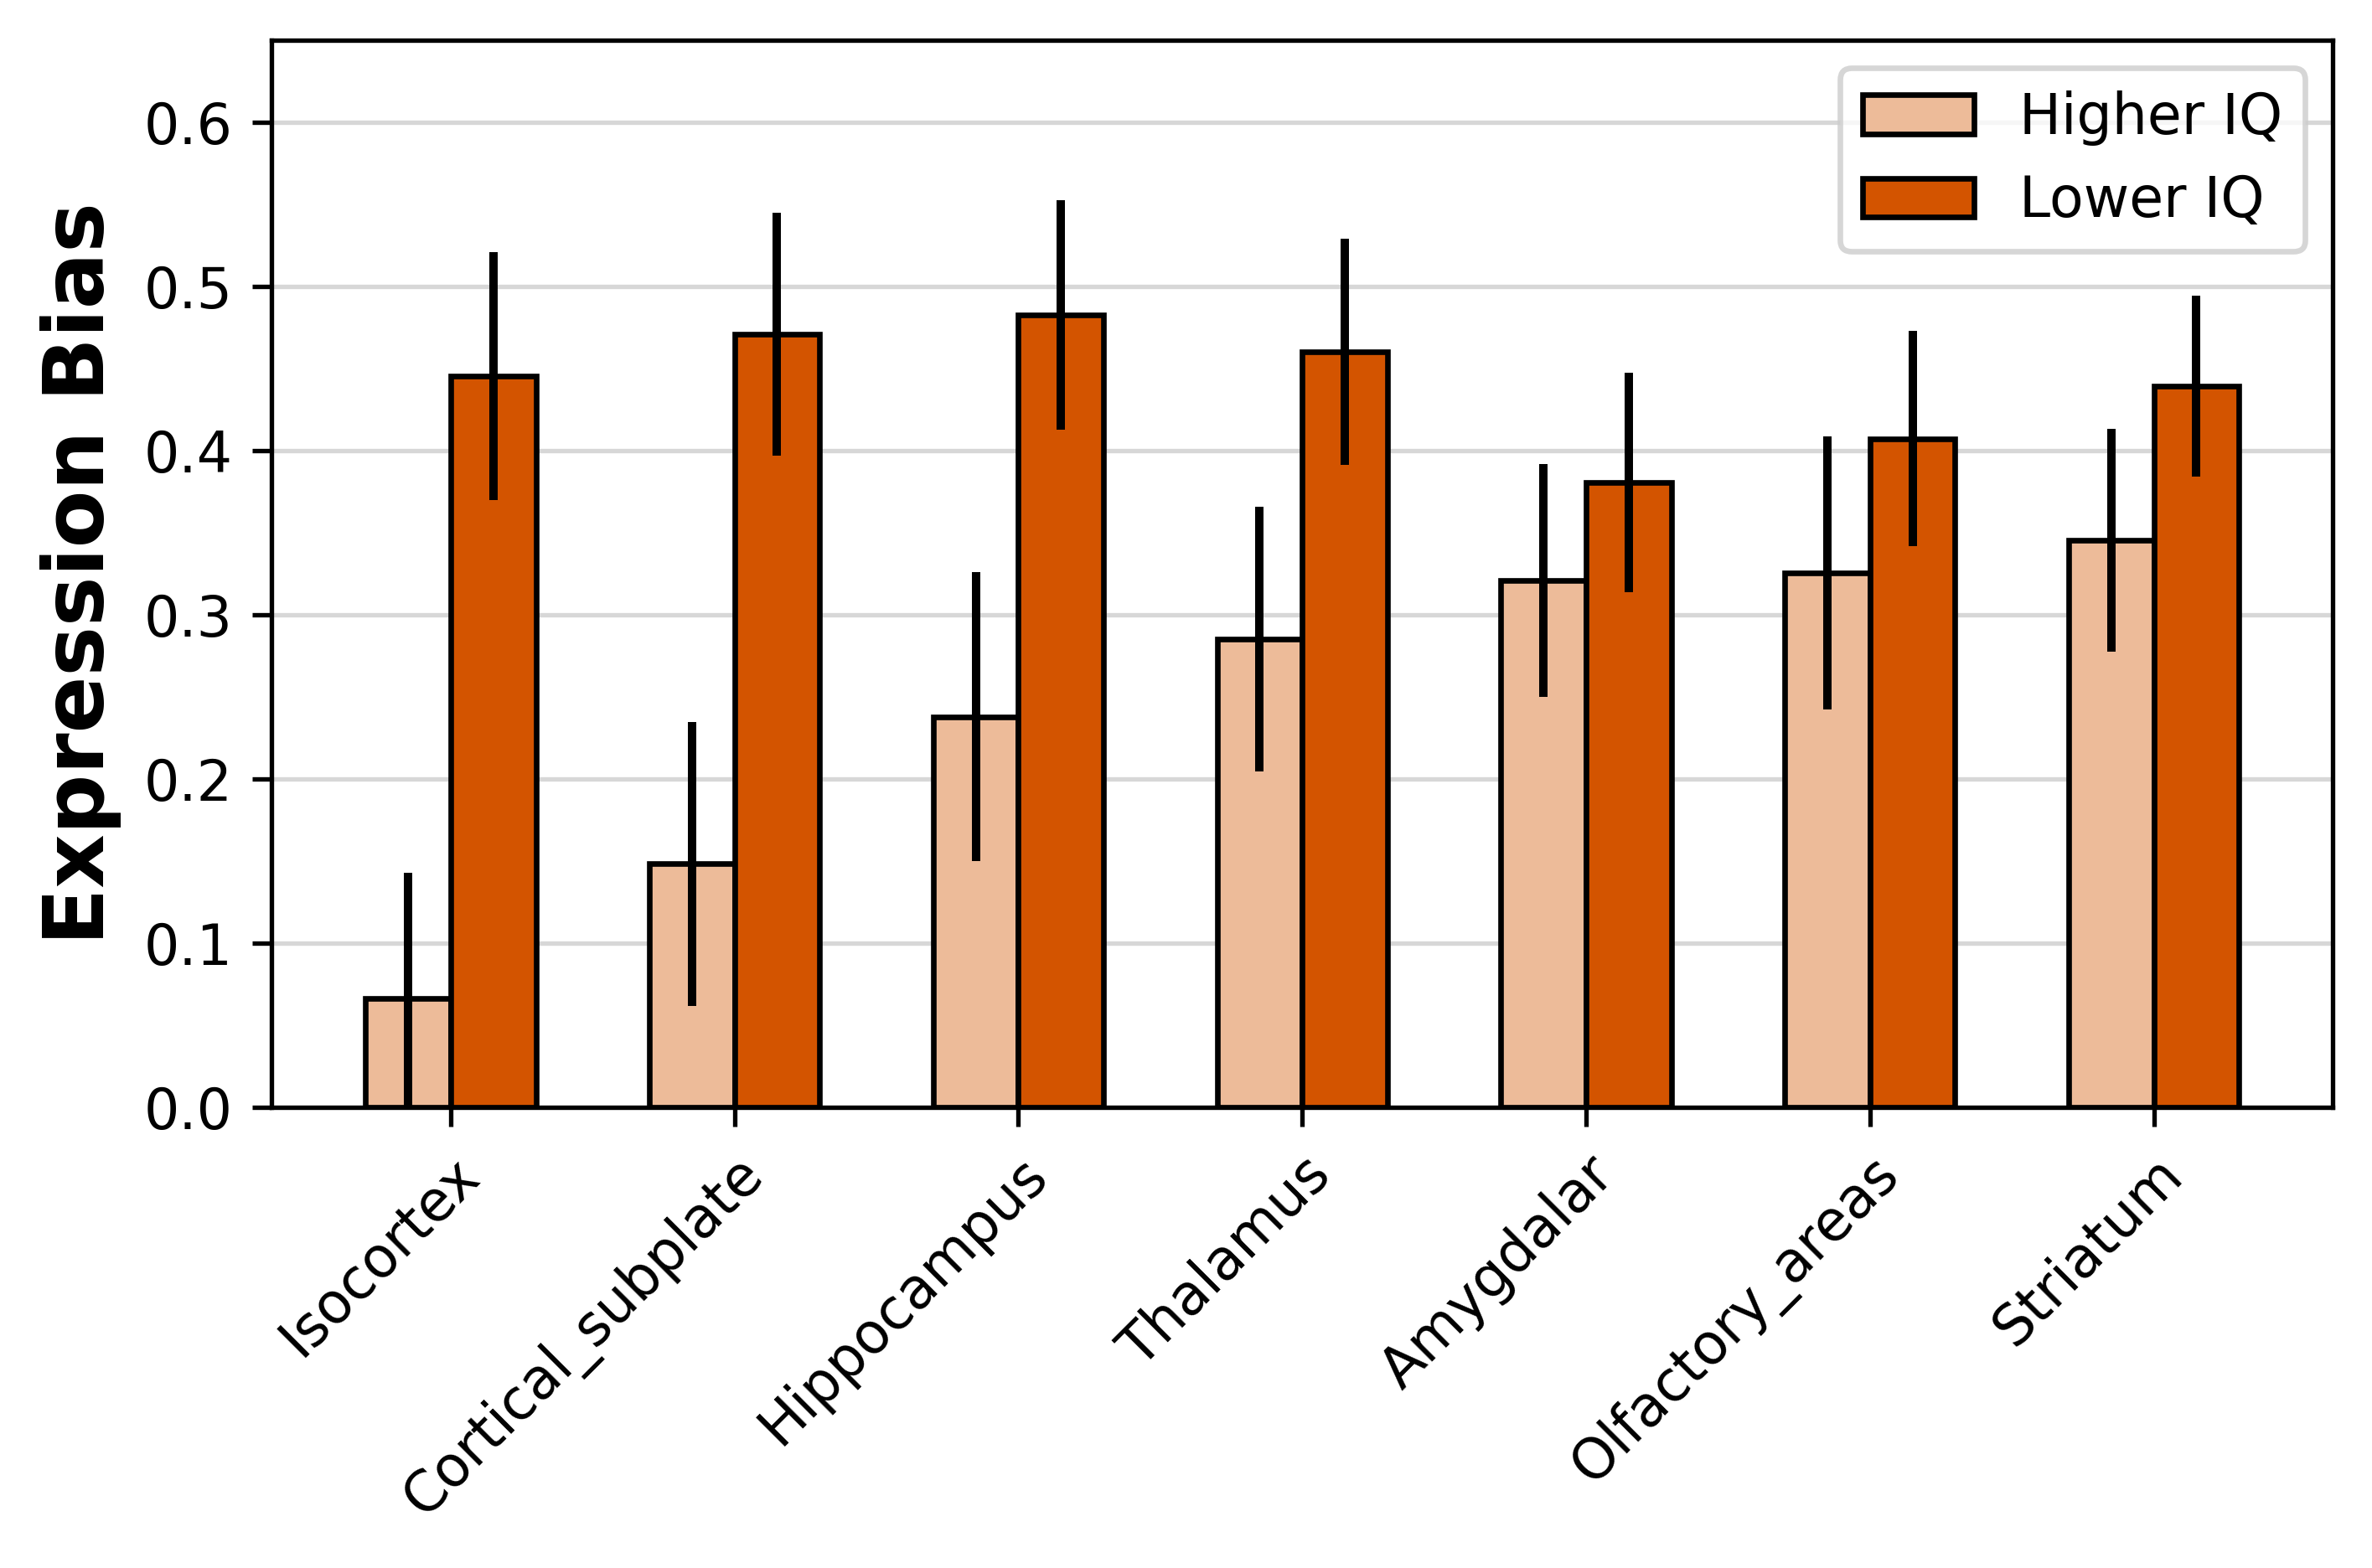

In [144]:
fig, ax = plt.subplots(dpi=480)

X = np.arange(len(CIR_REGIONS))

ax.bar(X - 0.15, HighIQ_dat[sort_idx], yerr=HighIQ_err[sort_idx], color="#EDBB99", width=0.3, label="Higher IQ", 
       edgecolor ='black')
ax.bar(X + 0.15, LowIQ_dat[sort_idx], yerr=LowIQ_err[sort_idx], color="#D35400", width=0.3, label="Lower IQ", 
   edgecolor ='black', hatch="")

ax.set_xlabel('', fontweight ='bold', fontsize = 15)
ax.set_ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS__[sort_idx], rotation=45, fontsize=10, ha='right', rotation_mode="anchor")
 
ax.legend()
plt.tight_layout()
ax.set_ylim(0, 0.65)
ax.grid(True, axis="y", alpha=0.5)
ax.set_axisbelow(True)
#pdf.savefig( fig )

In [ ]:
# P-value from permutation test

In [221]:
XXX = {"HighIQ":[], "LowIQ":[]}
for i in range(1, 10001):
    df1 = pd.read_csv("dat/IQ_permut/HighIQ_spec.bias.perm.{}.csv".format(i), index_col="STR")
    df2 = pd.read_csv("dat/IQ_permut/LowIQ_spec.bias.perm.{}.csv".format(i), index_col="STR")
    XXX["HighIQ"].append(df1)
    XXX["LowIQ"].append(df2)

In [208]:
def hahahaha(STR, XXX):
    res = []
    for i in range(0, 10000):
        #print(i, len(XXX["HighIQ"]))
        df1 = XXX["HighIQ"][i]
        df2 = XXX["LowIQ"][i]
        effect_diff = df2.loc[STR, "EFFECT"] - df1.loc[STR, "EFFECT"]
        res.append(effect_diff)
    return np.array(res)

In [209]:
#IQ_PhenotypeDF = IQ_PhenotypeDF.set_index("STR")

In [228]:
Region_Dat = {}
for Region in CIR_REGIONS_Dict.keys():
    STRs = CIR_REGIONS_Dict[Region]
    #print(Region, STRs)
    Region_Avg_Bias_Dat = []
    for i in range(10000):
        df1 = XXX["HighIQ"][i]
        df2 = XXX["LowIQ"][i]
        HIQ_Region_bias = df1.loc[STRs, "EFFECT"].mean()
        LIQ_Region_bias = df2.loc[STRs, "EFFECT"].mean()
        Diff = HIQ_Region_bias - LIQ_Region_bias
        Region_Avg_Bias_Dat.append([HIQ_Region_bias, LIQ_Region_bias, Diff])
    Region_Dat[Region] = np.array(Region_Avg_Bias_Dat)
    
#Format: HIQ_Region_bias, LIQ_Region_bias, Diff as columns, diff permutations as rows

In [229]:
Region_Dat["Isocortex"]

array([[ 0.2864603 ,  0.16351102,  0.12294929],
       [ 0.16229926,  0.23745752, -0.07515825],
       [ 0.20347028,  0.23871175, -0.03524146],
       ...,
       [ 0.27026769,  0.15712124,  0.11314645],
       [ 0.2289446 ,  0.20219482,  0.02674978],
       [ 0.26414946,  0.21122533,  0.05292413]])

Isocortex 0.23406884417220603 0.23397232412199193 9.652005021414638e-05
9.652005021414638e-05 -0.3790635457418151 9.999000099991662e-05


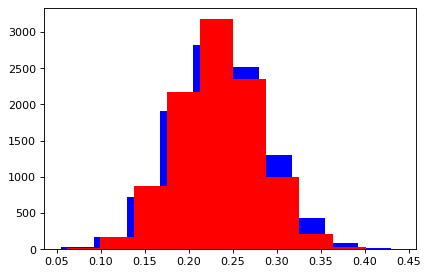

Hippocampus 0.37718594713025844 0.37747503429806595 -0.0002890871678074304
-0.0002890871678074304 -0.24462445779960332 0.008299170082991747


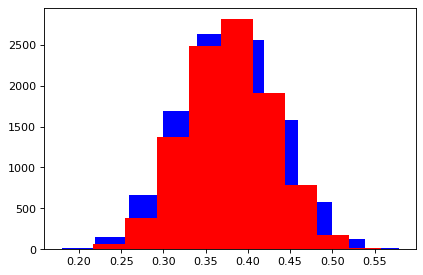

Cortical_subplate 0.2573296200872726 0.25611721541312565 0.0012124046741468913
0.0012124046741468913 -0.32265484141355655 0.0006999300069993053


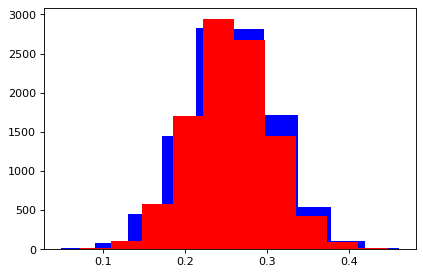

Amygdalar 0.30679994016260176 0.30553862699433015 0.0012613131682715879
0.0012613131682715879 -0.05982962929122615 0.24297570242975708


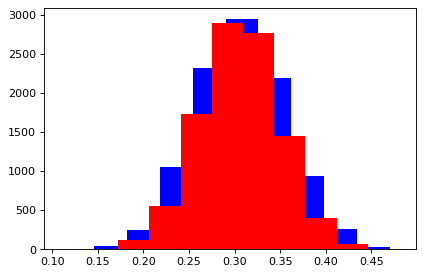

Striatum 0.26692503755526714 0.2659627297628627 0.0009623077924043592
0.0009623077924043592 -0.0936728205533025 0.12738726127387257


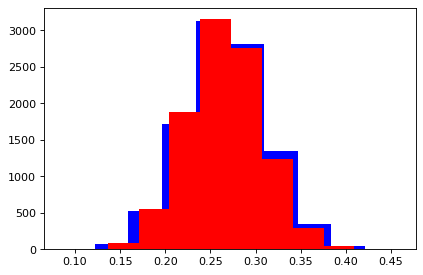

Thalamus 0.3198427587473543 0.3190875003288894 0.0007552584184649275
0.0007552584184649275 -0.17520502320690923 0.03389661033896607


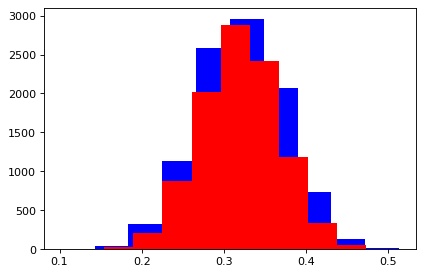

Olfactory_areas 0.3047530144619409 0.30553149287592457 -0.0007784784139836053
-0.0007784784139836053 -0.08170313754202407 0.19318068193180682


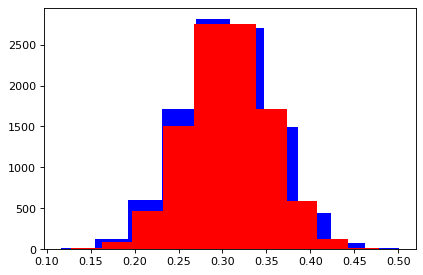

In [239]:
#HighIQ_Spec
#LowIQ_Spec
for Region in CIR_REGIONS_Dict.keys():
    STRs = CIR_REGIONS_Dict[Region]
    print(Region, Region_Dat[Region][:, 0].mean(), Region_Dat[Region][:, 1].mean(), 
          Region_Dat[Region][:, 2].mean())
    HIQ_Region_bias = HighIQ_Spec.loc[STRs, "EFFECT"].mean()
    LIQ_Region_bias = LowIQ_Spec.loc[STRs, "EFFECT"].mean()
    permut_diff = Region_Dat[Region][:, 2]
    Diff = HIQ_Region_bias - LIQ_Region_bias
    Z, P = GetPermutationP(permut_diff, Diff, gt=False)
    print(np.mean(permut_diff), Diff, P)
    
    fig, ax = plt.subplots()
    ax.hist(Region_Dat[Region][:, 0], color="blue", label="HIQ")
    ax.hist(Region_Dat[Region][:, 1], color="red", label="LIQ")
    plt.show()

In [218]:
#STR = "Nucleus_accumbens"
#permut_diff = hahahaha(STR, XXX)
#ax = plt.subplots()
#PlotPermutationP(permut_diff, IQ_PhenotypeDF.loc[STR, "Bias Diff (low-high)"], ax)

In [212]:
IQ_PhenotypeDF

,REG,HighIQ Bias,LowIQ Bias,HighIQ Rank,LowIQ Rank,Bias Diff (low-high),Rank Diff
STR,,,,,,,
Lateral_amygdalar_nucleus,Amygdalar,0.114696,0.657740,83,1,0.543044,-82
Orbital_area_lateral_part,Isocortex,0.318852,0.511921,19,11,0.193069,-8
Prelimbic_area,Isocortex,0.144356,0.628168,72,2,0.483812,-70
Dentate_gyrus,Hippocampus,0.434602,0.615106,9,3,0.180504,-6
Nucleus_accumbens,Striatum,0.316722,0.546284,20,8,0.229562,-12
Orbital_area_ventrolateral_part,Isocortex,0.136663,0.487451,76,18,0.350788,-58
Anterior_pretectal_nucleus,Midbrain,0.640817,0.433758,1,27,-0.207060,26
Basomedial_amygdalar_nucleus,Amygdalar,0.482540,0.359510,6,45,-0.123030,39
Lateral_posterior_nucleus_of_the_thalamus,Thalamus,0.413872,0.572267,10,6,0.158395,-4


In [213]:
DataDF_dat = []
for i, row in IQ_PhenotypeDF.iterrows():
    STR = i
    REG = row["REG"]
    Diff = row["Bias Diff (low-high)"]
    HighIQ = row["HighIQ Bias"]
    LowIQ = row["LowIQ Bias"]
    permut_diff = hahahaha(STR, XXX)
    Z, P = GetPermutationP(permut_diff, Diff, gt=True)
    IQ_PhenotypeDF.loc[i, "Pvalue"] = P
    print("%s %.3f %.3f %.3f %.3e" % (STR, HighIQ, LowIQ, Diff, P))

Lateral_amygdalar_nucleus 0.115 0.658 0.543 9.999e-05
Orbital_area_lateral_part 0.319 0.512 0.193 5.019e-02
Prelimbic_area 0.144 0.628 0.484 3.000e-04
Dentate_gyrus 0.435 0.615 0.181 9.939e-02
Nucleus_accumbens 0.317 0.546 0.230 1.880e-02
Orbital_area_ventrolateral_part 0.137 0.487 0.351 1.300e-03
Anterior_pretectal_nucleus 0.641 0.434 -0.207 9.158e-01
Basomedial_amygdalar_nucleus 0.483 0.360 -0.123 8.816e-01
Lateral_posterior_nucleus_of_the_thalamus 0.414 0.572 0.158 9.919e-02
Infralimbic_area 0.088 0.576 0.488 2.000e-04
Intercalated_amygdalar_nucleus 0.595 0.312 -0.284 9.929e-01
Endopiriform_nucleus_dorsal_part 0.213 0.480 0.267 1.200e-02
Claustrum 0.111 0.533 0.422 2.000e-04
Nucleus_of_reuniens 0.216 0.514 0.297 9.799e-03
Anterior_olfactory_nucleus 0.523 0.424 -0.099 7.600e-01
Primary_somatosensory_area_lower_limb 0.120 0.460 0.341 1.900e-03
Dorsal_peduncular_area 0.080 0.510 0.430 2.000e-04
Field_CA3 0.248 0.494 0.245 2.560e-02
Subiculum_ventral_part 0.106 0.425 0.319 4.200e-03
Fie

ValueError: shape mismatch: objects cannot be broadcast to a single shape

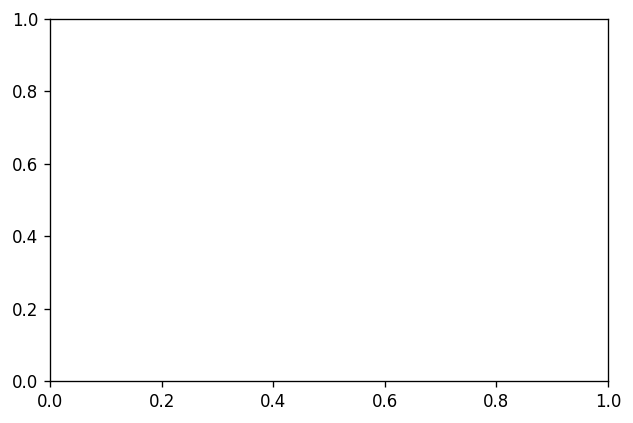

In [136]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))
for i, g in enumerate(["HIQ", "LIQ"]):
    ax.bar(X -0.3 + 0.2 * i, data2[i], color=color_map[g], width=0.2, label=g, 
           edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.tight_layout()
pdf.savefig( fig )

In [43]:
pdf.close()

In [137]:
REG_Layer1 = {}
REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
REG_Layer2["Cortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
REG_Layer2["Subcortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in REG_Layer1:
        REG_Layer1[REG] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
    REG_Layer1[REG]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    REG_Layer2[Broder]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])

In [138]:
data = []
for group in ["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(REG_Layer2[Broder][group]))
    data.append(tmp)
data = np.array(data)
data = data.transpose()

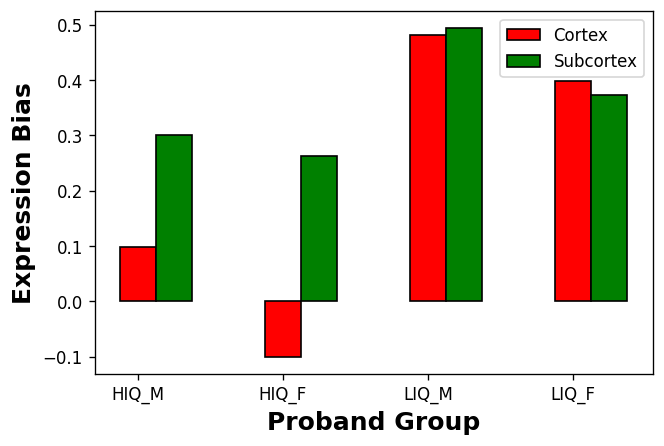

In [139]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(4)
ax.bar(X + 0.00, data[0], color='red', width=0.25, label="Cortex", edgecolor ='black')
ax.bar(X + 0.25, data[1], color='green', width=0.25, label="Subcortex", edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, ['HIQ_M', 'HIQ_F', 'LIQ_M', 'LIQ_F'])
 
plt.legend()
plt.show()

In [140]:
data2 = []
for group in ["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]:
    tmp = []
    for Narrow in CIR_REGIONS:
        tmp.append(np.median(REG_Layer1[Narrow][group]))
    data2.append(tmp)
data2 = np.array(data2)
#data2 = data.transpose()

In [141]:
color_map = {"HIQ_M":"lightsalmon", "HIQ_F":"greenyellow", 
             "LIQ_M":"red", "LIQ_F":"darkolivegreen"}

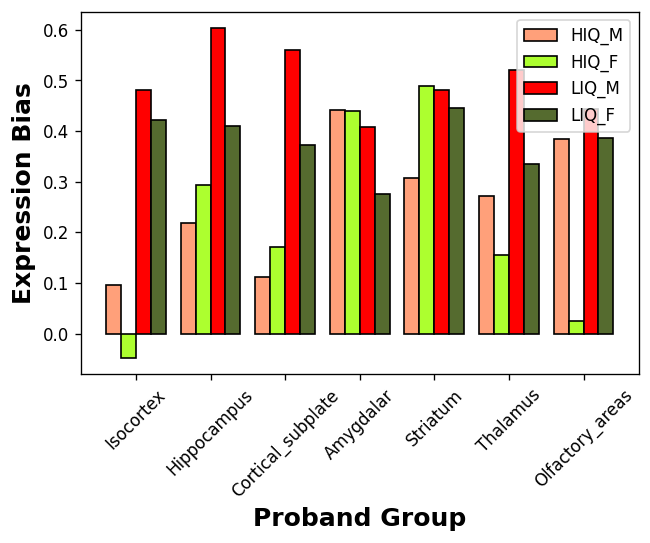

In [142]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))
for i, g in enumerate(["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]):
    ax.bar(X -0.3 + 0.2 * i, data2[i], color=color_map[g], width=0.2, label=g, 
           edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.show()

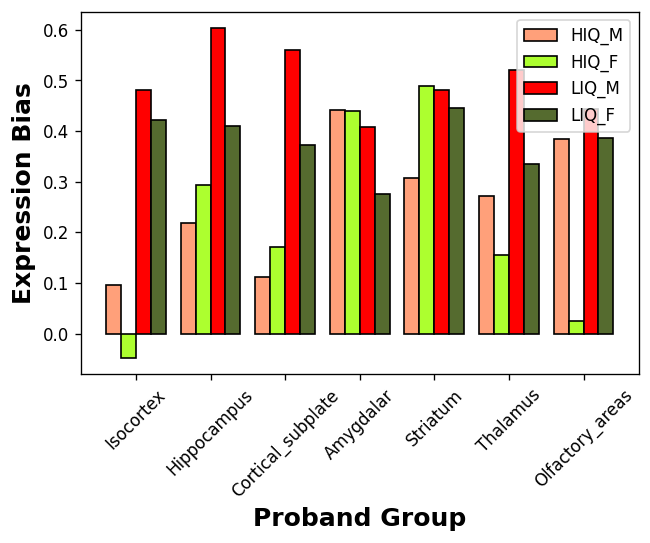

In [143]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))
for i, g in enumerate(["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]):
    ax.bar(X -0.3 + 0.2 * i, data2[i], color=color_map[g], width=0.2, label=g, 
           edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.show()

In [185]:
ASD_Discov_Muts

,Cohort,FamID,IID,Sex,Pheno,DNASource,VarID,Chrom,Position,Ref,...,pExt_HBDR,HGNCv24,DS_AG,DS_AL,DS_DG,DS_DL,DP_AG,DP_AL,DP_DG,DP_DL
0,MSSNG,FAM_D4S2Z,D4S2Z-01,Male,Affected,.,10:102239623:C:T,10,102239623,C,...,1,WNT8B,0.0038,0,0,0,28,-21,28,-43
1,MSSNG,FAM_2-1540-003,2-1540-003,Male,Affected,Blood,10:102689078:G:C,10,102689078,G,...,0.73,SLF2,0,0,0.0001,0,-4,1,34,1
2,MSSNG,FAM_1-0337-003,1-0337-003,Male,Affected,White_blood_cell,10:102750651:G:A,10,102750651,G,...,1,TWNK,0.0032,0,0.0001,0,2,15,2,13
3,MSSNG,FAM_F0215,REACH000457,Female,Uncertain,.,10:103436134:C:T,10,103436134,C,...,1,FBXW4,0,0,0,0.0151,-36,50,26,-36
4,MSSNG,FAM_2-1738-001,2-1738-003,Male,Affected,Blood,10:103825375:C:A,10,103825375,C,...,1,HPS6,0,0,0.0035,0,2,14,9,-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30999,SPARK,SF0142373,SP0142373,Female,Affected,Saliva,4:1388472:GT:AC,4,1388472,GT,...,1,CRIPAK,.,.,.,.,.,.,.,.
31000,SPARK,SF0142390,SP0142390,Female,Affected,Saliva,19:49964134:GA:AT,19,49964134,GA,...,1,ALDH16A1,.,.,.,.,.,.,.,.
31001,SPARK,SF0144606,SP0144606,Female,Affected,Saliva,X:41204685:AT:C,X,41204685,AT,...,0.908,DDX3X,.,.,.,.,.,.,.,.
31002,SPARK,SF0144774,SP0144775,Male,Unaffected,Saliva,12:122667753:G:TT,12,122667753,G,...,0.01,LRRC43,.,.,.,.,.,.,.,.


In [186]:
HighIQ

,Sample,Phenotype_ID,Sex,Role,IQ,age_of_walking,Categorical_intellectual_disability_status,ASDp_carrier,ASDndd_carrier
2,SSC02178,11001.p1,Male,Proband,124.0,13.0,No,No,No
3,SSC03070,11002.p1,Female,Proband,100.0,15.0,No,No,No
5,11003.p1,11003.p1,Male,Proband,109.0,13.0,No,No,No
9,SSC00556,11005.p1,Male,Proband,99.0,15.0,No,No,No
11,5316,11006.p1,Male,Proband,109.0,11.0,No,No,No
...,...,...,...,...,...,...,...,...,...
8604,TAS_F7099Y,TAS_F7099Y,Male,Proband,86.0,NaN,No,No,No
8605,TAS_F7219Y,TAS_F7219Y,Male,Proband,102.0,NaN,No,No,No
8606,TAS_F8030Y,TAS_F8030Y,Male,Proband,93.0,NaN,No,No,No
8607,TAS_F8054Y,TAS_F8054Y,Male,Proband,120.0,NaN,No,No,No


In [187]:
HighIQ_muts = ASD_Discov_Muts[ASD_Discov_Muts["IID"].isin(HighIQ["Phenotype_ID"].values)]
LowIQ_muts = ASD_Discov_Muts[ASD_Discov_Muts["IID"].isin(LowIQ["Phenotype_ID"].values)]
print(HighIQ_muts.shape, LowIQ_muts.shape)

(4128, 44) (2201, 44)


In [188]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn

def Mut2GeneDF(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["HGNC"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        gene2MutN[Entrez] = N_LGD * w_LGD + N_Dmis * w_Dmis
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [189]:
HighIQ_muts_LGD_Mis = Filt_LGD_Mis(HighIQ_muts, Dmis=True)
LowIQ_muts_LGD_Mis = Filt_LGD_Mis(LowIQ_muts, Dmis=True)
print(HighIQ_muts_LGD_Mis.shape, LowIQ_muts_LGD_Mis.shape)

(1070, 44) (643, 44)


In [190]:
# Select top ASD genes LGD/Dmis mutations
Spark_Meta = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/asd/spark_Meta_top_genes.xlsx")
HighConfGenes = Spark_Meta["HGNC"].values
HighIQ_Proband_HC = HighIQ_muts_LGD_Mis[HighIQ_muts_LGD_Mis["HGNC"].isin(HighConfGenes)]
HighIQ_Proband_HC.to_csv("dat/ASD_Proband_HC_HighIQ_LGD_Dmis.csv", index=False)
LowIQ_Proband_HC = LowIQ_muts_LGD_Mis[LowIQ_muts_LGD_Mis["HGNC"].isin(HighConfGenes)]
LowIQ_Proband_HC.to_csv("dat/ASD_Proband_HC_LowIQ_LGD_Dmis.csv", index=False)
print(HighIQ_Proband_HC.shape, LowIQ_Proband_HC.shape)

(142, 44) (157, 44)


In [191]:
Whole_Proband_IQ_Muts = HighIQ_Proband_HC.append(LowIQ_Proband_HC, ignore_index=True)

In [192]:
Probands_IQ_Mut_in_HC = Whole_Proband_IQ_Muts["IID"].values
Proband_HC_IQ = IQ_dat[IQ_dat["Phenotype_ID"].isin(Probands_IQ_Mut_in_HC)]

In [193]:
Whole_Proband_IQ_Muts.to_csv("dat/IQ_HC_muts.csv", index=False)
Proband_HC_IQ.to_csv("dat/IQ_HC_Phenotype.csv", index=False)

In [194]:
Proband_HC_IQ_perm = Proband_HC_IQ.copy(deep=True)
Proband_HC_IQ_perm["IQ"] = np.random.permutation(Proband_HC_IQ_perm["IQ"].values)

In [195]:
Proband_HC_IQ

,Sample,Phenotype_ID,Sex,Role,IQ,age_of_walking,Categorical_intellectual_disability_status,ASDp_carrier,ASDndd_carrier
50,11041.p1,11041.p1,Male,Proband,47.0,16.0,Yes,No,No
127,SSC00344,11114.p1,Female,Proband,40.0,12.0,Yes,No,Yes
154,SSC03230,11145.p1,Male,Proband,76.0,14.0,No,No,No
155,5328,11148.p1,Male,Proband,86.0,17.0,No,Yes,No
181,68527,11169.p1,Male,Proband,85.0,12.0,No,No,No
...,...,...,...,...,...,...,...,...,...
8547,200675722@1082034785,200675722@1082034785,Male,Proband,83.0,12.0,No,Yes,No
8564,TAS_F0207X,TAS_F0207X,Female,Proband,49.0,NaN,Yes,No,Yes
8565,TAS_F4013Y,TAS_F4013Y,Male,Proband,95.0,NaN,No,No,Yes
8567,TAS_F3039Y,TAS_F3039Y,Male,Proband,74.0,NaN,No,Yes,No


In [196]:
Proband_HC_IQ_perm

,Sample,Phenotype_ID,Sex,Role,IQ,age_of_walking,Categorical_intellectual_disability_status,ASDp_carrier,ASDndd_carrier
50,11041.p1,11041.p1,Male,Proband,53.0,16.0,Yes,No,No
127,SSC00344,11114.p1,Female,Proband,129.0,12.0,Yes,No,Yes
154,SSC03230,11145.p1,Male,Proband,43.0,14.0,No,No,No
155,5328,11148.p1,Male,Proband,77.0,17.0,No,Yes,No
181,68527,11169.p1,Male,Proband,75.0,12.0,No,No,No
...,...,...,...,...,...,...,...,...,...
8547,200675722@1082034785,200675722@1082034785,Male,Proband,73.0,12.0,No,Yes,No
8564,TAS_F0207X,TAS_F0207X,Female,Proband,40.0,NaN,Yes,No,Yes
8565,TAS_F4013Y,TAS_F4013Y,Male,Proband,89.0,NaN,No,No,Yes
8567,TAS_F3039Y,TAS_F3039Y,Male,Proband,83.0,NaN,No,Yes,No


## bias for two IQ group

In [201]:
HighIQ_gene2MutN = Mut2GeneDF(HighIQ_Proband_HC, 0.347, 0.194)
#Agg_Match = pd.read_csv("dat/Final_Spark_Meta.Matches.csv", index_col="GENE")
HighIQ_Spec = AvgSTRZ_Weighted(ExpZ2Mat, HighIQ_gene2MutN, 
                                 Method = 1, csv_fil = "dat/bias2/HighIQ_spec.bias.csv")

In [202]:
LowIQ_gene2MutN = Mut2GeneDF(LowIQ_Proband_HC, 0.347, 0.194)
LowIQ_Spec = AvgSTRZ_Weighted(ExpZ2Mat, LowIQ_gene2MutN, 
                                 Method = 1, csv_fil = "dat/bias2/LowIQ_spec.bias.csv")

In [203]:
HighIQ_Spec = HighIQ_Spec.set_index("STR")
LowIQ_Spec = LowIQ_Spec.set_index("STR")

## STR bias for circuit STRs

In [64]:
Circuit_STRs = pd.read_csv("dat/Circuit_GN_42.csv")["STR"].values

In [65]:
len(Circuit_STRs)

43

In [204]:
HighIQ_Spec = pd.read_csv("dat/bias2/ASD.HIQ_spec.bias.csv", index_col="STR")
LowIQ_Spec = pd.read_csv("dat/bias2/ASD.LIQ_spec.bias.csv", index_col="STR")

In [205]:
str2reg = STR2Region()
IQ_Phenotype_dat = []
for STR in Circuit_STRs:
    Region = str2reg[STR]
    A_effect = HighIQ_Spec.loc[STR, "EFFECT"]
    B_effect = LowIQ_Spec.loc[STR, "EFFECT"]
    A_rank = HighIQ_Spec.loc[STR, "Rank"]
    B_rank = LowIQ_Spec.loc[STR, "Rank"]
    BiasDiff = B_effect - A_effect
    RankDiff = B_rank - A_rank
    IQ_Phenotype_dat.append([STR, Region, A_effect, B_effect, 
                             A_rank, B_rank, BiasDiff, RankDiff])
IQ_PhenotypeDF = pd.DataFrame(IQ_Phenotype_dat, columns=["STR", "REG", "HighIQ Bias", 
            "LowIQ Bias", "HighIQ Rank", "LowIQ Rank", "Bias Diff (low-high)", "Rank Diff"])
IQ_PhenotypeDF.to_csv("dat/IQ_Bias_Diff.csv", index=False)

In [206]:
writer = pd.ExcelWriter('dat/IQ_Bias.xlsx', engine='xlsxwriter')
IQ_PhenotypeDF.to_excel(writer, sheet_name='IQ_Bias_42_Circuits')
HighIQ_Spec.to_excel(writer, sheet_name='HighIQ_Spec')
LowIQ_Spec.to_excel(writer, sheet_name='LowIQ_Spec')
writer.save()

## XXXXX

In [50]:
adj_mat = pd.read_csv(ConnFil, index_col=0)
g = LoadConnectome2(adj_mat) # Load Connectiome
EdgeWeightsDict = EdgeDict(g, keyon="label")
#str2reg = STR2Region()
#str2reg_df = pd.read_csv(MajorBrainDivisions, delimiter="\t")

In [60]:
EdgeWeightsDict = {}
topNs = list(range(200, 10, -5))
ASD_Conn_Z, ASD_Cohe_Z, ASD_Conn_P, ASD_Cohe_P, ASD_Conn_E, ASD_Cohe_E = [],[],[],[],[],[]
Sib_Conn_Z, Sib_Cohe_Z, Sib_Conn_P, Sib_Cohe_P, Sib_Conn_E, Sib_Cohe_E = [],[],[],[],[],[]
for topN in topNs:
    Permuted_ASD_cohe = []
    Permuted_ASD_conn = []
    Permuted_Sib_cohe = []
    Permuted_Sib_conn = []
    for i in range(1000):
        adj_mat_perm = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
        g_perm = LoadConnectome2(adj_mat_perm)
        asd_cohe, asd_conn = ScoreSTRSet(g_perm, HighIQ_Spec.head(topN).index.values, EdgeWeightsDict)
        sib_cohe, sib_conn = ScoreSTRSet(g_perm, LowIQ_Spec.head(topN).index.values, EdgeWeightsDict)
        Permuted_ASD_cohe.append(asd_cohe)
        Permuted_ASD_conn.append(asd_conn)
        Permuted_Sib_cohe.append(sib_cohe)
        Permuted_Sib_conn.append(sib_conn)
    asd_cohe, asd_conn = ScoreSTRSet(g, HighIQ_Spec.head(topN).index.values, EdgeWeightsDict)
    sib_cohe, sib_conn = ScoreSTRSet(g, LowIQ_Spec.head(topN).index.values, EdgeWeightsDict)
    
    asd_z_conn, asd_p_conn = GetPermutationP(Permuted_ASD_conn, asd_conn)
    asd_z_cohe, asd_p_cohe = GetPermutationP(Permuted_ASD_cohe, asd_cohe)
    effect_conn = asd_conn/np.mean(Permuted_ASD_conn)
    effect_cohe = asd_cohe/np.mean(Permuted_ASD_cohe)
    ASD_Conn_Z.append(asd_z_conn); ASD_Cohe_Z.append(asd_z_cohe)
    ASD_Conn_P.append(asd_p_conn); ASD_Cohe_P.append(asd_p_cohe)
    ASD_Conn_E.append(effect_conn); ASD_Cohe_E.append(effect_cohe)
    
    sib_z_conn, sib_p_conn = GetPermutationP(Permuted_Sib_conn, sib_conn)
    sib_z_cohe, sib_p_cohe = GetPermutationP(Permuted_Sib_cohe, sib_cohe)
    effect_conn = sib_conn/np.mean(Permuted_Sib_conn)
    effect_cohe = sib_cohe/np.mean(Permuted_Sib_cohe)
    Sib_Conn_Z.append(sib_z_conn); Sib_Cohe_Z.append(sib_z_cohe)
    Sib_Conn_P.append(sib_p_conn); Sib_Cohe_P.append(sib_p_cohe)
    Sib_Conn_E.append(effect_conn); Sib_Cohe_E.append(effect_cohe)

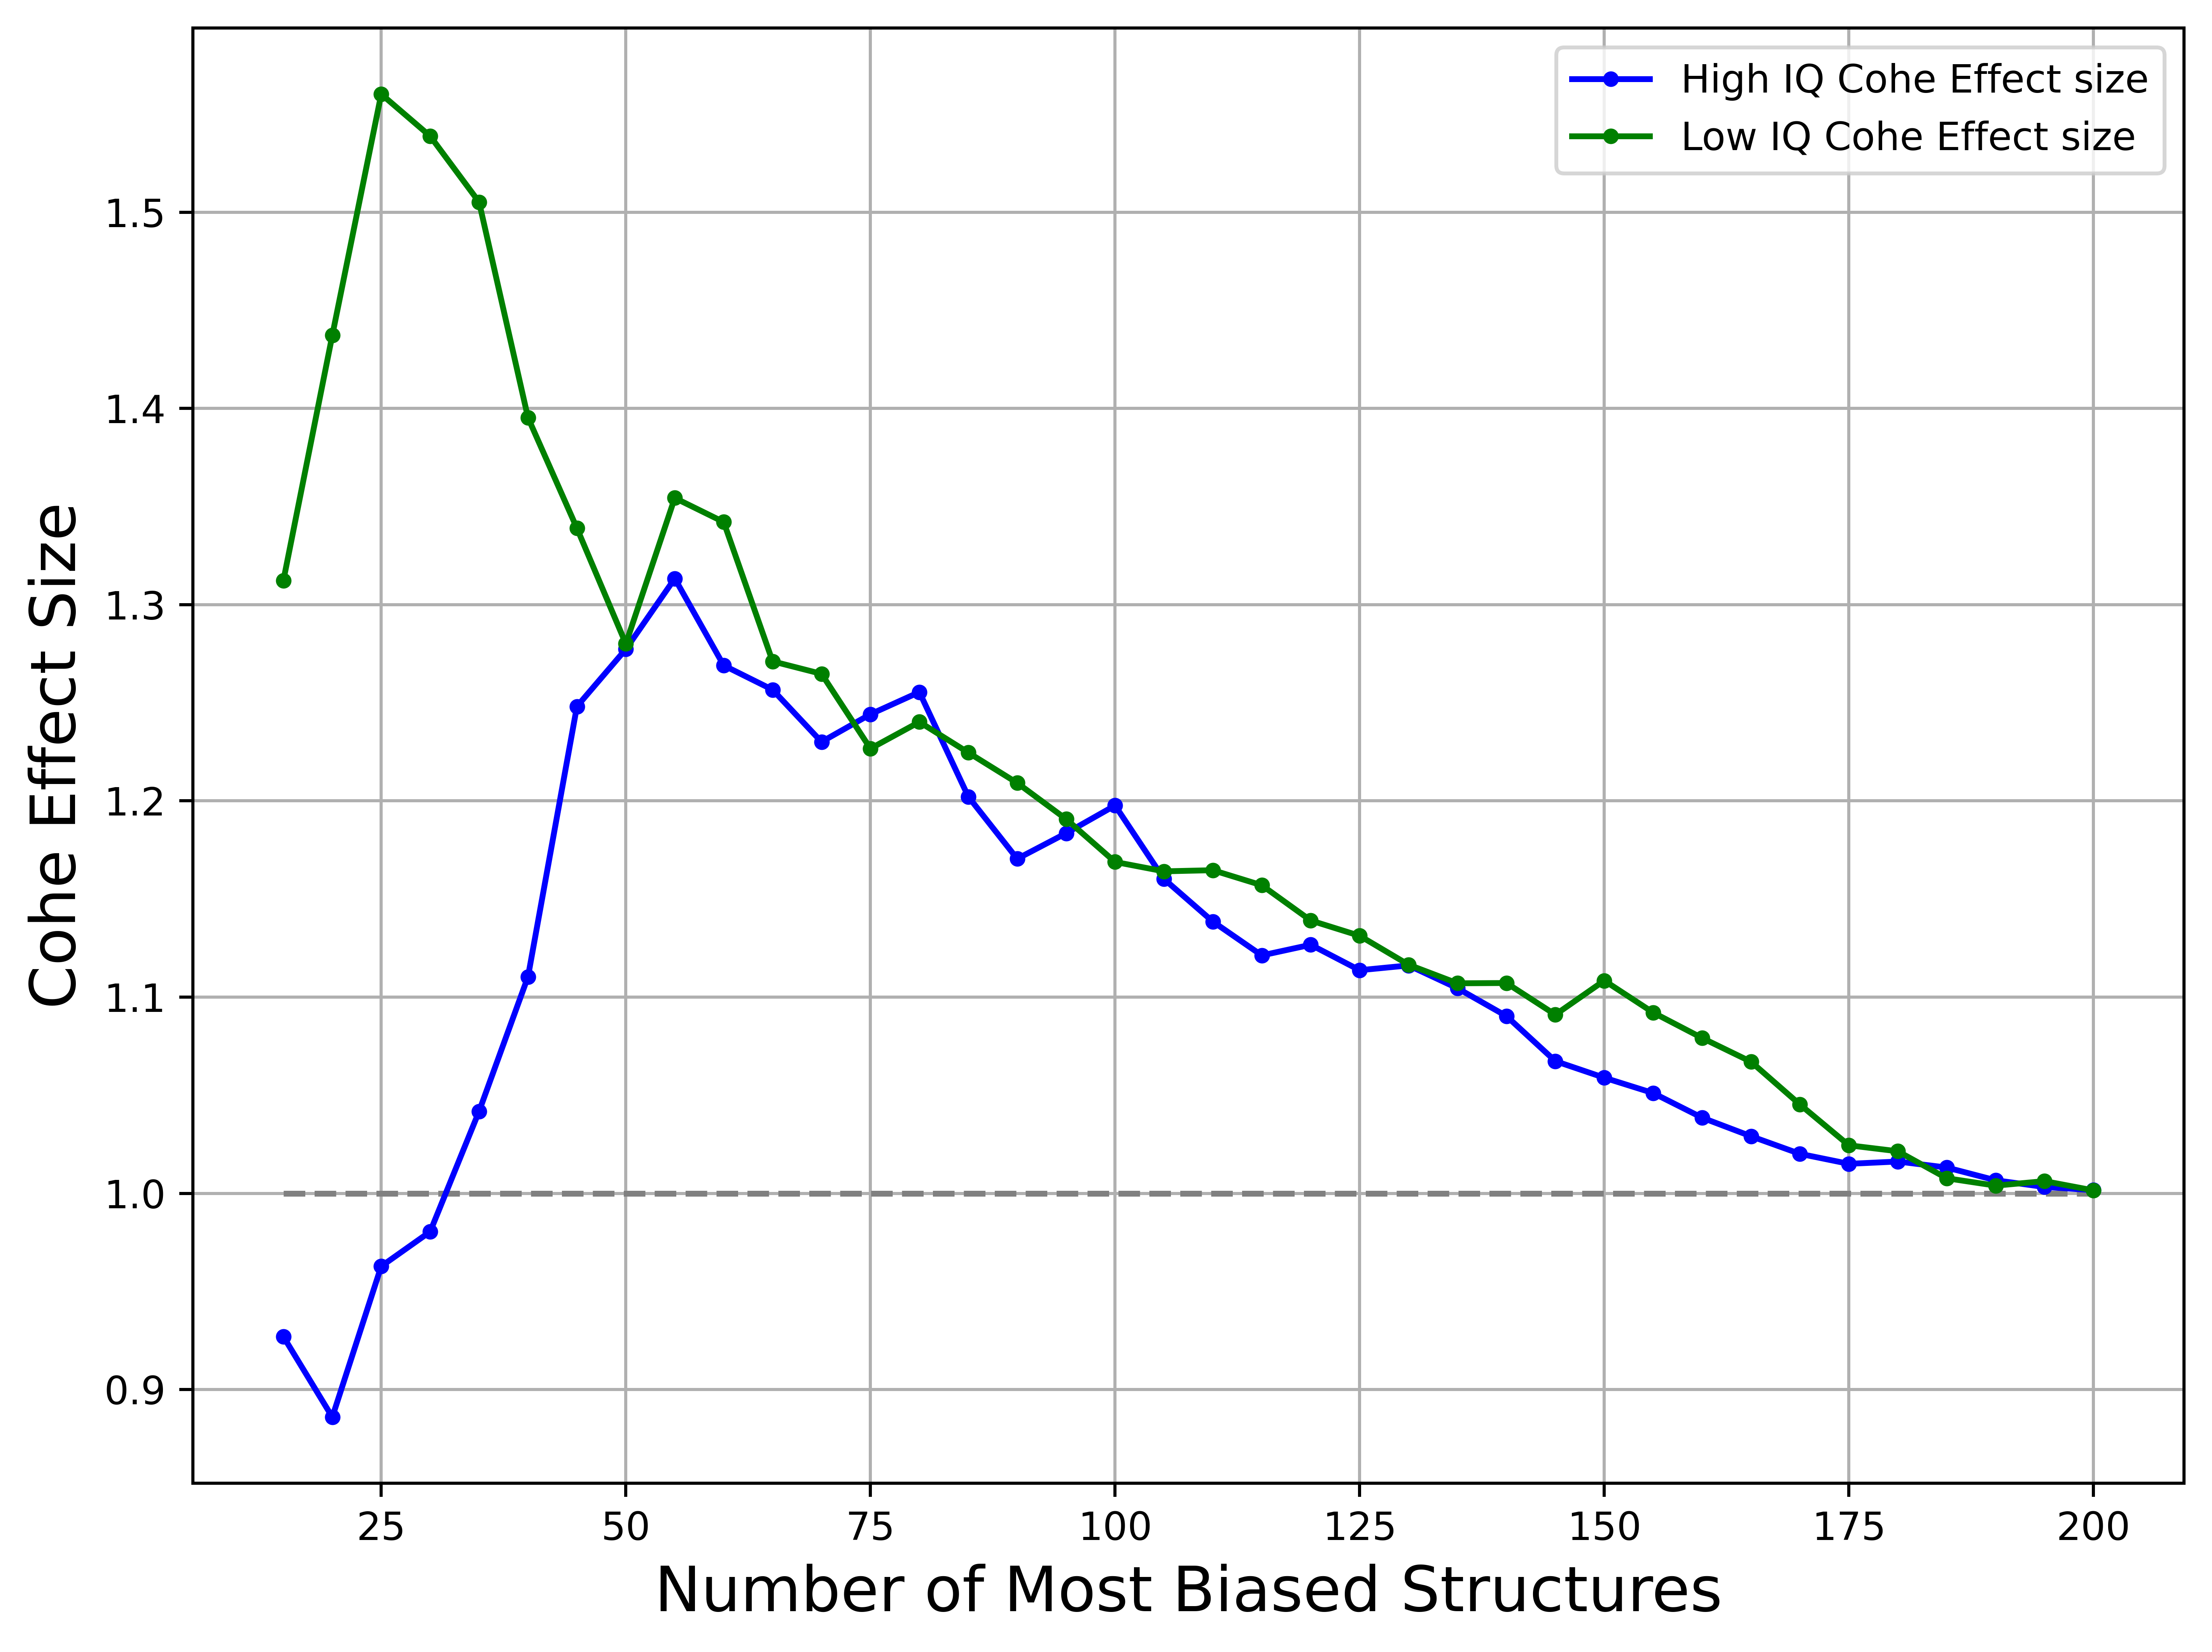

In [62]:
ASD_Conn_P = np.array(ASD_Conn_P)
fig, ax = plt.subplots(dpi=720, figsize=(8,6))

ax.plot(topNs, ASD_Cohe_E, label="High IQ Cohe Effect size", marker=".", color="blue")
ax.plot(topNs, Sib_Cohe_E, label="Low IQ Cohe Effect size", marker=".", color="green")

ax.hlines(xmin=min(topNs), xmax=max(topNs), y=1, ls="--", color="grey")
ax.grid(True)
ax.legend()
ax.set_ylabel("Cohe Effect Size",fontsize=16)
ax.set_xlabel("Number of Most Biased Structures",fontsize=16)


plt.tight_layout()

In [54]:
LowIQ_Spec.head(26).index.values

array(['Field_CA1', 'Dentate_gyrus', 'Field_CA2',
       'Lateral_amygdalar_nucleus', 'Prelimbic_area', 'Infralimbic_area',
       'Field_CA3', 'Lateral_posterior_nucleus_of_the_thalamus',
       'Subiculum_dorsal_part', 'Dorsal_peduncular_area', 'Claustrum',
       'Subiculum_ventral_part', 'Nucleus_of_reuniens',
       'Orbital_area_lateral_part', 'Anteromedial_visual_area',
       'Lateral_septal_nucleus_ventral_part', 'Nucleus_accumbens',
       'Anterior_pretectal_nucleus', 'Orbital_area_medial_part',
       'Mediodorsal_nucleus_of_thalamus',
       'Endopiriform_nucleus_dorsal_part',
       'Submedial_nucleus_of_the_thalamus',
       'Orbital_area_ventrolateral_part', 'Rhomboid_nucleus',
       'Agranular_insular_area_posterior_part',
       'Anterior_cingulate_area_dorsal_part'], dtype=object)

In [55]:
HighIQ_Spec.head(50).index.values

array(['Accessory_olfactory_bulb', 'Intercalated_amygdalar_nucleus',
       'Anterior_olfactory_nucleus',
       'Lateral_septal_nucleus_ventral_part',
       'Anterior_pretectal_nucleus', 'Dentate_gyrus',
       'Basomedial_amygdalar_nucleus', 'Mediodorsal_nucleus_of_thalamus',
       'Central_amygdalar_nucleus', 'Parafascicular_nucleus',
       'Parataenial_nucleus', 'Orbital_area_lateral_part',
       'Lateral_posterior_nucleus_of_the_thalamus',
       'Nucleus_of_the_posterior_commissure',
       'Nucleus_of_the_optic_tract',
       'Subparafascicular_nucleus_magnocellular_part', 'Parasubiculum',
       'Lateral_septal_nucleus_rostral_rostroventral_part',
       'Dorsomedial_nucleus_of_the_hypothalamus', 'Field_CA3',
       'Submedial_nucleus_of_the_thalamus',
       'Superior_central_nucleus_raphe', 'Subparafascicular_area',
       'Dorsal_peduncular_area', 'Posterior_complex_of_the_thalamus',
       'Endopiriform_nucleus_dorsal_part', 'Nucleus_of_reuniens',
       'Bed_nuclei_of_

In [56]:
HighIQ_Spec.head(50)

,EFFECT,REGION,Rank
STR,,,
Accessory_olfactory_bulb,0.427930,Olfactory_areas,1
Intercalated_amygdalar_nucleus,0.412990,Striatum,2
Anterior_olfactory_nucleus,0.406311,Olfactory_areas,3
Lateral_septal_nucleus_ventral_part,0.395143,Striatum,4
Anterior_pretectal_nucleus,0.381859,Midbrain,5
Dentate_gyrus,0.364890,Hippocampal_region,6
Basomedial_amygdalar_nucleus,0.349336,Cortical_subplate,7
Mediodorsal_nucleus_of_thalamus,0.346189,Thalamus,8
Central_amygdalar_nucleus,0.342902,Striatum,9


In [64]:
LowIQ_Spec.head(55)

,EFFECT,REGION,Rank
STR,,,
Field_CA1,0.624907,Hippocampal_region,1
Dentate_gyrus,0.610407,Hippocampal_region,2
Field_CA2,0.550272,Hippocampal_region,3
Lateral_amygdalar_nucleus,0.509946,Cortical_subplate,4
Prelimbic_area,0.504669,Isocortex,5
Infralimbic_area,0.474459,Isocortex,6
Field_CA3,0.471555,Hippocampal_region,7
Lateral_posterior_nucleus_of_the_thalamus,0.443449,Thalamus,8
Subiculum_dorsal_part,0.437142,Hippocampal_formation,9


## XXXX

In [188]:
# Load 1000 permutated expression bias
XXX = {"HighIQ":[], "LowIQ":[]}
for i in range(1, 10001):
    df1 = pd.read_csv("dat/IQ_permut/HighIQ_spec.bias.perm.{}.csv".format(i), index_col="STR")
    df2 = pd.read_csv("dat/IQ_permut/LowIQ_spec.bias.perm.{}.csv".format(i), index_col="STR")
    XXX["HighIQ"].append(df1)
    XXX["LowIQ"].append(df2)

In [189]:
print(len(XXX["HighIQ"]))

10000


In [190]:
def hahahaha(STR, XXX):
    res = []
    for i in range(0, 10000):
        #print(i, len(XXX["HighIQ"]))
        df1 = XXX["HighIQ"][i]
        df2 = XXX["LowIQ"][i]
        effect_diff = df2.loc[STR, "EFFECT"] - df1.loc[STR, "EFFECT"]
        res.append(effect_diff)
    return np.array(res)

In [203]:
IQ_PhenotypeDF = IQ_PhenotypeDF.set_index("STR")

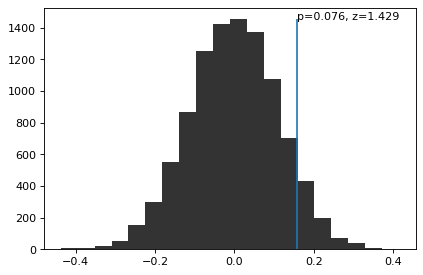

In [206]:
STR = "Nucleus_accumbens"
permut_diff = hahahaha(STR, XXX)
PlotPermutationP(permut_diff, IQ_PhenotypeDF.loc[STR, "Bias Diff (low-high)"])

In [191]:
DataDF_dat = []
for i, row in IQ_PhenotypeDF.iterrows():
    STR = row["STR"]
    REG = row["REG"]
    Diff = row["Bias Diff (low-high)"]
    HighIQ = row["HighIQ Bias"]
    LowIQ = row["LowIQ Bias"]
    permut_diff = hahahaha(STR, XXX)
    Z, P = GetPermutationP(permut_diff, Diff, gt=True)
    IQ_PhenotypeDF.loc[i, "Pvalue"] = P
    print("%s %.3f %.3f %.3f %.3e" % (STR, HighIQ, LowIQ, Diff, P))

Anterior_cingulate_area_dorsal_part 0.064 0.339 0.275 9.499e-03
Nucleus_accumbens 0.214 0.372 0.159 7.629e-02
Agranular_insular_area_posterior_part 0.131 0.348 0.216 2.060e-02
Agranular_insular_area_ventral_part 0.207 0.333 0.126 1.094e-01
Accessory_olfactory_bulb 0.428 0.309 -0.119 8.215e-01
Anterior_olfactory_nucleus 0.406 0.280 -0.126 8.140e-01
Basolateral_amygdalar_nucleus 0.051 0.312 0.261 1.870e-02
Bed_nuclei_of_the_stria_terminalis 0.218 0.274 0.056 2.913e-01
Central_amygdalar_nucleus 0.343 0.214 -0.129 8.910e-01
Claustrum 0.126 0.408 0.282 6.599e-03
Caudoputamen 0.111 0.241 0.130 1.327e-01
Dorsal_peduncular_area 0.232 0.432 0.201 4.050e-02
Endopiriform_nucleus_dorsal_part 0.228 0.365 0.137 1.238e-01
Frontal_pole_cerebral_cortex 0.119 0.253 0.133 1.543e-01
Gustatory_areas 0.080 0.303 0.223 2.120e-02
Intercalated_amygdalar_nucleus 0.413 0.280 -0.133 8.712e-01
Infralimbic_area 0.182 0.474 0.292 6.299e-03
Mediodorsal_nucleus_of_thalamus 0.346 0.365 0.019 4.490e-01
Primary_motor_are

In [192]:
# Let's make a plot
CIR_REGIONS = list(set(IQ_PhenotypeDF["REG"].values))

In [193]:
CIR_REGIONS = ['Isocortex', 'Hippocampal_formation', 'Hippocampal_region', 
    'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
 'Olfactory_areas']

In [194]:
#Color_dict = dict(zip(CIR_REGIONS, [""]))
color_dict = {"Amygdalar":"yellow","Isocortex":"skyblue", "Thalamus": "red", 
              "Striatum":"brown", "Olfactory_areas":"cyan", 
             "Hippocampal_formation":"green", "Hippocampal_region":"olive", 
              "Cortical_subplate":"purple", "Midbrain":"pink", "Pallidum":"Brown"}

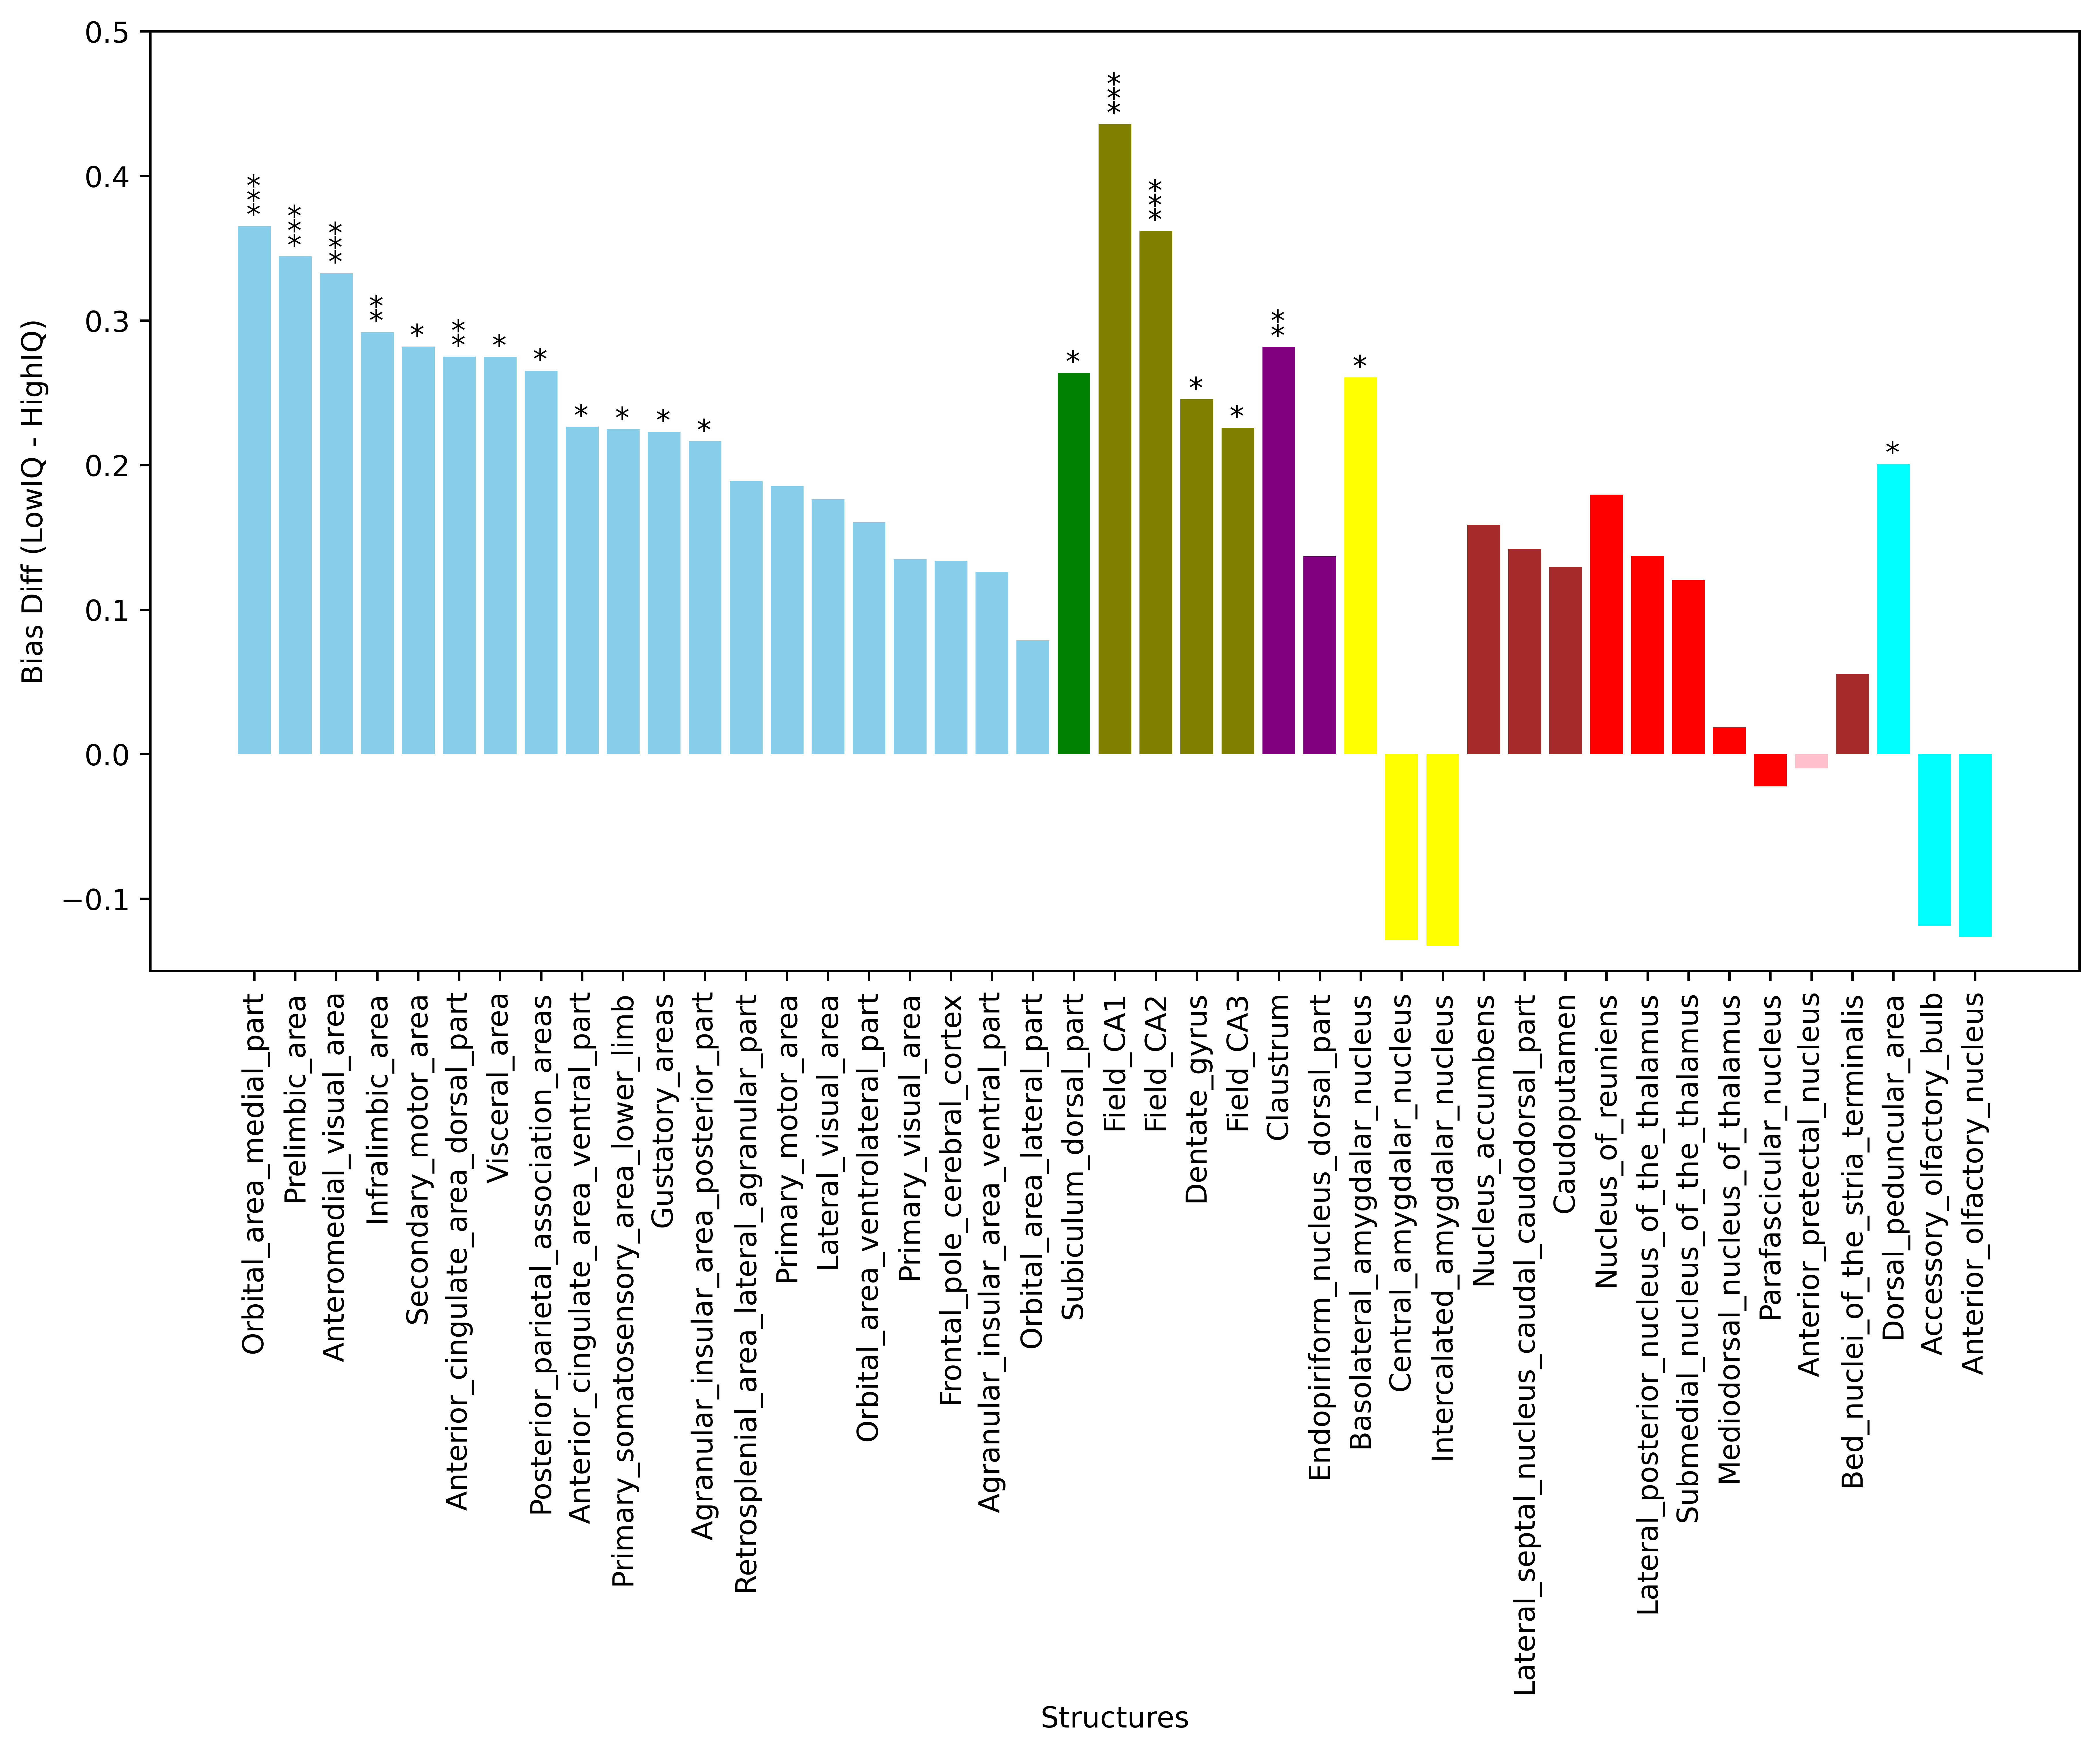

In [200]:
idx = 1
fig, ax = plt.subplots(dpi=720, figsize=(12,6))
STR_labels = []
for REG in CIR_REGIONS:
    #print(REG)
    xx = IQ_PhenotypeDF[IQ_PhenotypeDF["REG"]==REG]
    xx = xx.sort_values("Bias Diff (low-high)", ascending=False)
    for i, row in xx.iterrows():
        STR = row["STR"]
        REG = row["REG"]
        Diff = row["Bias Diff (low-high)"]
        Pvalue = row["Pvalue"]
        #print(STR, REG, Pvalue)
        ax.bar(idx, Diff, color=color_dict[REG])
        STR_labels.append(STR)
        if Pvalue < 0.05:
            ax.text(idx-0.20, Diff+0.001, s="*", color="black")
        if Pvalue < 0.01:
            ax.text(idx-0.20, Diff+0.011, s="*", color="black")
        if Pvalue < 0.005:
            ax.text(idx-0.20, Diff+0.021, s="*", color="black")
        idx += 1
ax.set_ylabel("Bias Diff (LowIQ - HighIQ)")
ax.set_xlabel("Structures")
ax.set_ylim(-0.15, 0.5)
ax.set_xticks(range(1, idx))
ax.set_xticklabels(STR_labels, rotation=90)
plt.show()

In [235]:
Cortex = ['Isocortex', 'Cortical_subplate']
Subcortex = ['Hippocampal_formation', 'Hippocampal_region', 'Amygdalar', 'Striatum', 
             'Thalamus', 'Midbrain', 'Pallidum', 'Olfactory_areas']

In [ ]:
['Isocortex', 'Hippocampal_formation', 'Hippocampal_region', 
    'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
 'Olfactory_areas']

## Cognitive Impairment

In [ ]:
Cog_impair_dat = pd.read_excel()

In [241]:
ASD_Discov_Trios.head(2)

,Cohort,FamID,FamHist,IID,Sex,Pheno,CognitImpair
0,ASC,UCD_11791,Simplex,002-09-110644,Male,Affected,No
1,ASC,UCD_10455,Multiplex,003-05-102508,Female,Affected,No


In [243]:
ASD_Discov_Trios = ASD_Discov_Trios.set_index("IID")

In [244]:
IQ_dat = IQ_dat.set_index("Phenotype_ID")

In [245]:
for i, row in IQ_dat.iterrows():
    try:
        CognitImpair = ASD_Discov_Trios.loc[i, "CognitImpair"]
        IQ_dat.loc[i, "CognitImpair"] = CognitImpair
    except:
        IQ_dat.loc[i, "CognitImpair"] = "NA"

In [247]:
Cog_impair_IQs = IQ_dat[IQ_dat["CognitImpair"]=="Yes"]["IQ"].values
Not_Cog_impair_IQs = IQ_dat[IQ_dat["CognitImpair"]=="No"]["IQ"].values

(array([7.66295269e-05, 3.57604459e-04, 1.83910865e-03, 1.42786352e-02,
        2.01024792e-02, 1.94638998e-02, 1.01150975e-02, 3.42278553e-03,
        5.87493039e-04, 1.78802229e-04]),
 array([ 25. ,  39.2,  53.4,  67.6,  81.8,  96. , 110.2, 124.4, 138.6,
        152.8, 167. ]),
 <BarContainer object of 10 artists>)

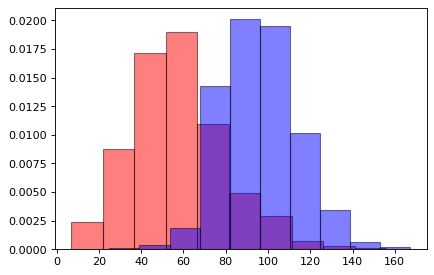

In [252]:
plt.hist(Cog_impair_IQs, color="red", label="Cog Impair", 
         alpha=0.5, density=1, edgecolor='black')
plt.hist(Not_Cog_impair_IQs, color="blue", label="Not Cog Impair", 
         alpha=0.5, density=1, edgecolor='black')

#### Diff Probands

In [332]:
xx_Probands = IQ_dat[(IQ_dat["CognitImpair"]=="Yes") & (IQ_dat["IQ"]>70)
                    ].index.values # IQ > 70 but marked as cog impair

In [340]:
xx_Probands2 = IQ_dat[(IQ_dat["CognitImpair"]=="No") & (IQ_dat["IQ"]<70)
                    ].index.values # IQ > 70 but marked as cog impair

In [342]:
XX_Muts2 = HighConfMuts[HighConfMuts["IID"].isin(xx_Probands2)]

In [334]:
XX_Muts = HighConfMuts[HighConfMuts["IID"].isin(xx_Probands)]

In [344]:
xx_GW2 = Mut2GeneDF(XX_Muts2, 0.347, 0.194) # Not use weights input
xx_Spec2 = AvgSTRZ_Weighted(ExpZ2Mat, xx_GW2, 
                                 Method = 1, csv_fil = "dat/bias2/xx2.bias.csv")

In [345]:
xx_Spec2 = xx_Spec2[xx_Spec2["STR"].isin(Circuit_STRs)]

In [346]:
xx_Spec2

,STR,EFFECT,REGION,Rank
0,Anterior_olfactory_nucleus,0.909777,Olfactory_areas,1
1,Lateral_posterior_nucleus_of_the_thalamus,0.837806,Thalamus,2
2,Claustrum,0.837557,Cortical_subplate,3
3,Orbital_area_lateral_part,0.828237,Isocortex,4
4,Primary_somatosensory_area_lower_limb,0.819950,Isocortex,5
5,Endopiriform_nucleus_dorsal_part,0.816761,Cortical_subplate,6
6,Orbital_area_ventrolateral_part,0.768563,Isocortex,7
7,Primary_motor_area,0.757361,Isocortex,8
9,Agranular_insular_area_ventral_part,0.728908,Isocortex,10
10,Agranular_insular_area_posterior_part,0.728068,Isocortex,11


In [337]:
xx_GW = Mut2GeneDF(XX_Muts, 0.347, 0.194) # Not use weights input
xx_Spec = AvgSTRZ_Weighted(ExpZ2Mat, xx_GW, 
                                 Method = 1, csv_fil = "dat/bias2/xx.bias.csv")

In [338]:
xx_Spec = xx_Spec[xx_Spec["STR"].isin(Circuit_STRs)]

In [339]:
xx_Spec

,STR,EFFECT,REGION,Rank
0,Lateral_posterior_nucleus_of_the_thalamus,0.917494,Thalamus,1
1,Anterior_pretectal_nucleus,0.875006,Midbrain,2
2,Intercalated_amygdalar_nucleus,0.852950,Amygdalar,3
8,Parataenial_nucleus,0.628440,Thalamus,9
10,Basomedial_amygdalar_nucleus,0.591358,Amygdalar,11
12,Lateral_septal_nucleus_ventral_part,0.579256,Striatum,13
18,Parafascicular_nucleus,0.544679,Thalamus,19
23,Field_CA3,0.516736,Hippocampus,24
24,Lateral_septal_nucleus_caudal_caudodorsal_part,0.504574,Striatum,25
26,Nucleus_of_reuniens,0.479849,Thalamus,27


## ASC Cog

In [251]:
ASC_Cog = IQ_dat[IQ_dat["CognitImpair"]=="Yes"].index.values
ASC_NoCog = IQ_dat[IQ_dat["CognitImpair"]=="No"].index.values
print(len(ASC_Cog), len(ASC_NoCog))

1719 2757


In [253]:
ASC_Cog_Muts = HighConfMuts[HighConfMuts["IID"].isin(ASC_Cog)]
ASC_NoCog_Muts = HighConfMuts[HighConfMuts["IID"].isin(ASC_NoCog)]

In [255]:
ASC_Cog_Muts.to_csv("dat/ASC.ES.Cog.muts.csv", index=False)
ASC_NoCog_Muts.to_csv("dat/ASC.ES.NoCog.muts.csv", index=False)

In [257]:
ASC_Cog_GW = Mut2GeneDF(ASC_Cog_Muts, 0.347, 0.194) # Not use weights input
ASC_Cog_Spec = AvgSTRZ_Weighted(ExpZ2Mat, ASC_Cog_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASC.Cog.bias.csv")

ASC_NoCog_GW = Mut2GeneDF(ASC_NoCog_Muts, 0.347, 0.194)
ASC_NoCog_Spec = AvgSTRZ_Weighted(ExpZ2Mat, ASC_NoCog_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASC.NoCog.bias.csv")

In [258]:
ASC_Cog_Spec = ASC_Cog_Spec.set_index("STR")
ASC_NoCog_Spec = ASC_NoCog_Spec.set_index("STR")

In [320]:
Cog_REG_Layer1 = {}
Cog_REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
Cog_REG_Layer2["Cortex"] = {"Cog":[], "NoCog":[]}
Cog_REG_Layer2["Subcortex"] = {"Cog":[], "NoCog":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in Cog_REG_Layer1:
        Cog_REG_Layer1[REG] = {"Cog":[], "NoCog":[]}
    Cog_REG_Layer1[REG]['Cog'].append(ASC_Cog_Spec.loc[STR, "EFFECT"])
    Cog_REG_Layer1[REG]['NoCog'].append(ASC_NoCog_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    Cog_REG_Layer2[Broder]['Cog'].append(ASC_Cog_Spec.loc[STR, "EFFECT"])
    Cog_REG_Layer2[Broder]['NoCog'].append(ASC_NoCog_Spec.loc[STR, "EFFECT"])

In [261]:
Cog_data = []
for group in ["Cog", "NoCog"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(Cog_REG_Layer2[Broder][group]))
    Cog_data.append(tmp)
Cog_data = np.array(Cog_data)
Cog_data = data.transpose()

In [321]:
Cog_data = [[np.mean(Cog_REG_Layer2["Cortex"]['Cog']), 
             np.mean(Cog_REG_Layer2["Cortex"]['NoCog'])],
            [np.mean(Cog_REG_Layer2["Subcortex"]['Cog']), 
             np.mean(Cog_REG_Layer2["Subcortex"]['NoCog'])]]

In [ ]:
#HIQ_Cortex_boots = GetBootsDist(HIQ_DFs, Cortex_CirSTRs)
#HIQ_Subcor_boots = GetBootsDist(HIQ_DFs, Subcor_CirSTRs)
#LIQ_Cortex_boots = GetBootsDist(LIQ_DFs, Cortex_CirSTRs)
#LIQ_Subcor_boots = GetBootsDist(LIQ_DFs, Subcor_CirSTRs)
#error1 = [np.std(HIQ_Cortex_boots), np.std(LIQ_Cortex_boots)]
#error2 = [np.std(HIQ_Subcor_boots), np.std(LIQ_Subcor_boots)]

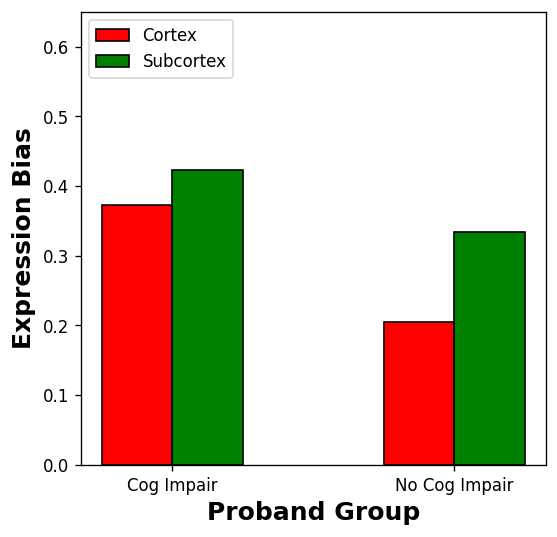

In [323]:
fig, ax = plt.subplots(dpi=120, figsize=(5,5))
X = np.arange(2)
ax.bar(X - 0.125, Cog_data[0], color='red', width=0.25, label="Cortex", edgecolor ='black')
ax.bar(X + 0.125, Cog_data[1], color='green', width=0.25, label="Subcortex", edgecolor ='black')

props = {'connectionstyle':'bar','arrowstyle':'-',\
             'shrinkA':20,'shrinkB':20,'linewidth':2}

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, ['Cog Impair', 'No Cog Impair'])
ax.set_ylim(0,0.65)
plt.legend(loc="upper left")

## Spark Cog Impair

In [265]:
ASD_Discov_Trios.head(2)

,Cohort,FamID,FamHist,Sex,Pheno,CognitImpair
IID,,,,,,
002-09-110644,ASC,UCD_11791,Simplex,Male,Affected,No
003-05-102508,ASC,UCD_10455,Multiplex,Female,Affected,No


In [282]:
Spark_Cog = ASD_Discov_Trios[ASD_Discov_Trios["CognitImpair"]=="Yes"].index.values
Spark_NoCog = ASD_Discov_Trios[ASD_Discov_Trios["CognitImpair"]=="No"].index.values

In [283]:
Spark_Cog_Muts = HighConfMuts[HighConfMuts["IID"].isin(Spark_Cog)]
Spark_NoCog_Muts = HighConfMuts[HighConfMuts["IID"].isin(Spark_NoCog)]

In [284]:
Spark_Cog_Muts.to_csv("dat/Spark.Discover.ES.Cog.muts.csv", index=False)
Spark_NoCog_Muts.to_csv("dat/Sparl.Discover.ES.NoCog.muts.csv", index=False)

In [285]:
Spark_Cog_GW = Mut2GeneDF(Spark_Cog_Muts, 0.347, 0.194) # Not use weights input
Spark_Cog_Spec = AvgSTRZ_Weighted(ExpZ2Mat, Spark_Cog_GW, 
                                 Method = 1, csv_fil = "dat/bias2/Spark.Cog.bias.csv")

Spark_NoCog_GW = Mut2GeneDF(Spark_NoCog_Muts, 0.347, 0.194)
Spark_NoCog_Spec = AvgSTRZ_Weighted(ExpZ2Mat, Spark_NoCog_GW, 
                                 Method = 1, csv_fil = "dat/bias2/Spark.NoCog.bias.csv")

In [286]:
Spark_Cog_Spec = Spark_Cog_Spec.set_index("STR")
Spark_NoCog_Spec = Spark_NoCog_Spec.set_index("STR")

In [298]:
Spark_Cog_Spec[Spark_Cog_Spec["REGION"]=="Isocortex"]["EFFECT"].mean()

0.30770288360235926

In [297]:
Spark_NoCog_Spec[Spark_NoCog_Spec["REGION"]=="Isocortex"]["EFFECT"].mean()

0.1967397731407022

In [302]:
Circuit_STRs

array(['Lateral_amygdalar_nucleus', 'Orbital_area_lateral_part',
       'Prelimbic_area', 'Dentate_gyrus', 'Nucleus_accumbens',
       'Orbital_area_ventrolateral_part', 'Anterior_pretectal_nucleus',
       'Basomedial_amygdalar_nucleus',
       'Lateral_posterior_nucleus_of_the_thalamus', 'Infralimbic_area',
       'Intercalated_amygdalar_nucleus',
       'Endopiriform_nucleus_dorsal_part', 'Claustrum',
       'Nucleus_of_reuniens', 'Anterior_olfactory_nucleus',
       'Primary_somatosensory_area_lower_limb', 'Dorsal_peduncular_area',
       'Field_CA3', 'Subiculum_ventral_part', 'Field_CA1',
       'Anteromedial_visual_area', 'Parafascicular_nucleus', 'Field_CA2',
       'Endopiriform_nucleus_ventral_part',
       'Lateral_septal_nucleus_ventral_part',
       'Agranular_insular_area_posterior_part',
       'Bed_nuclei_of_the_stria_terminalis', 'Visceral_area',
       'Caudoputamen', 'Retrosplenial_area_lateral_agranular_part',
       'Primary_motor_area', 'Primary_visual_area',
     

In [287]:
Cog_REG_Layer1 = {}
Cog_REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
Cog_REG_Layer2["Cortex"] = {"Cog":[], "NoCog":[]}
Cog_REG_Layer2["Subcortex"] = {"Cog":[], "NoCog":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in Cog_REG_Layer1:
        Cog_REG_Layer1[REG] = {"Cog":[], "NoCog":[]}
    Cog_REG_Layer1[REG]['Cog'].append(Spark_Cog_Spec.loc[STR, "EFFECT"])
    Cog_REG_Layer1[REG]['NoCog'].append(Spark_NoCog_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    Cog_REG_Layer2[Broder]['Cog'].append(Spark_Cog_Spec.loc[STR, "EFFECT"])
    Cog_REG_Layer2[Broder]['NoCog'].append(Spark_NoCog_Spec.loc[STR, "EFFECT"])

In [309]:
np.mean(Cog_REG_Layer2["Cortex"]['Cog'])

0.4637547211943734

In [308]:
np.mean(Cog_REG_Layer2["Cortex"]['NoCog'])

0.301363861044345

In [288]:
Cog_data = []
for group in ["Cog", "NoCog"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(Cog_REG_Layer2[Broder][group]))
    Cog_data.append(tmp)
Cog_data = np.array(Cog_data)
Cog_data = data.transpose()

In [314]:
Cog_data = [[np.mean(Cog_REG_Layer2["Cortex"]['Cog']), 
             np.mean(Cog_REG_Layer2["Cortex"]['NoCog'])],
            [np.mean(Cog_REG_Layer2["Subcortex"]['Cog']), 
             np.mean(Cog_REG_Layer2["Subcortex"]['NoCog'])]]

In [315]:
Cog_data

[[0.4637547211943734, 0.301363861044345],
 [0.4195254363683138, 0.3545043505918995]]

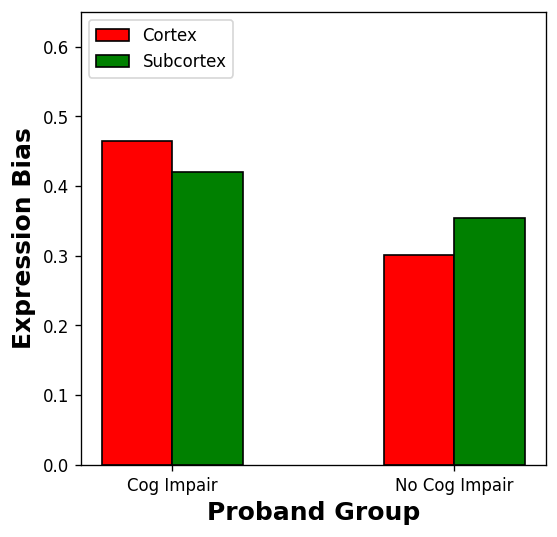

In [316]:
fig, ax = plt.subplots(dpi=120, figsize=(5,5))
X = np.arange(2)
ax.bar(X - 0.125, Cog_data[0], color='red', width=0.25, label="Cortex", edgecolor ='black')
ax.bar(X + 0.125, Cog_data[1], color='green', width=0.25, label="Subcortex", edgecolor ='black')

props = {'connectionstyle':'bar','arrowstyle':'-',\
             'shrinkA':20,'shrinkB':20,'linewidth':2}

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, ['Cog Impair', 'No Cog Impair'])
ax.set_ylim(0,0.65)
plt.legend(loc="upper left")

## ID

In [210]:
ID_muts = pd.read_csv("../dat/genes/Denovo-v.1.5.intellectualDisability.variants.tsv", 
                     delimiter="\t")
ID_genes = pd.read_excel("../dat/genes/41593_2016_BFnn4352_MOESM22_ESM.xls")

In [213]:
ID_genelist = ID_genes[ID_genes["FDR.significant?"]<0.05]["gene.name"].values

In [218]:
ID_HC_muts = ID_muts[ID_muts["Gene"].isin(ID_genelist)]

In [232]:
def CountMut2(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["FunctionClass"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            if float(row["CaddScore"]) > 30:
                N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn

def Mut2GeneDF2(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["Gene"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["Gene"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut2(Muts)
        gene2MutN[Entrez] = N_LGD * w_LGD + N_Dmis * w_Dmis
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [233]:
ID_gene2MutN = Mut2GeneDF2(ID_HC_muts, 0.347, 0.194)
ID_Match = MakeMatchDF(ID_gene2MutN, N=1000)
ID_Spec = AvgSTRZ_Weighted(ExpZscoreMat, ID_gene2MutN, Match_DF=ID_Match,
                                 Method = 2, csv_fil = "dat/bias2/ID_spec.bias.csv")

In [234]:
RD_Agg_avgZ_RD = RegionDistributions(ID_Spec.set_index("STR"), show=True, topN=50)

Olfactory_areas 	 2 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus
Amygdalar 	 5 	 Lateral_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Posterior_amygdalar_nucleus; Intercalated_amygdalar_nucleus; Basomedial_amygdalar_nucleus
Thalamus 	 12 	 Nucleus_of_reuniens; Dorsal_part_of_the_lateral_geniculate_complex; Intermediodorsal_nucleus_of_the_thalamus; Central_medial_nucleus_of_the_thalamus; Submedial_nucleus_of_the_thalamus; Ventral_medial_nucleus_of_the_thalamus; Subparafascicular_area; Subparafascicular_nucleus_magnocellular_part; Mediodorsal_nucleus_of_thalamus; Central_lateral_nucleus_of_the_thalamus; Rhomboid_nucleus; Paraventricular_nucleus_of_the_thalamus
Midbrain 	 3 	 Nucleus_of_the_posterior_commissure; Interpeduncular_nucleus; Ventral_tegmental_area
Striatum 	 1 	 Septofimbrial_nucleus
Hippocampal_formation 	 1 	 Entorhinal_area_lateral_part
Medulla 	 6 	 Paragigantocellular_reticular_nucleus_dorsal_part; Hypoglossal_nucleus; Nucleus_prepositus; Magnocellular_reticu

## Indv Probands Hit

In [249]:
HighConfMuts.shape

(693, 44)

In [251]:
IQ_dat = IQ_dat.set_index("Phenotype_ID")

In [253]:
HighConfMuts_wIQ = HighConfMuts[HighConfMuts["IID"].isin(IQ_dat.index.values)]

In [255]:
for i, row in HighConfMuts_wIQ.iterrows():
    proband = row["IID"]
    IQ = IQ_dat.loc[proband, "IQ"]#[IQ_dat["IQ"]>70]["Phenotype_ID"].values
    HighConfMuts_wIQ.loc[i, "IQ"] = IQ

/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [305]:
IQ_seq, N_CirSTR_IQ_seq = [], [] 
N_Cortex_CirSTR_IQ_seq, N_Subcortex_CirSTR_IQ_seq = [], []
HighIQ_STR_Counts = {}
LowIQ_STR_Counts = {}
N_highIQ, N_lowIQ = 0,0
for STR in Circuit_STRs:
    HighIQ_STR_Counts[STR] = 0
    LowIQ_STR_Counts[STR] = 0
for i, var in HighConfMuts_wIQ.iterrows():
    IQ = var["IQ"]
    Gene = var["HGNC"]
    Entrez = int(GeneSymbol2Entrez.get(Gene, 0))
    if Entrez == 0 or Entrez not in allen_mouse_genes:
        continue
    Spec = IndvZ2.loc[Entrez, :].sort_values(ascending=False).head(50).index.values
    Spec_in_cir = list(set(Spec).intersection(Circuit_STRs))
    Spec_in_cir_cortex = [x for x in Spec_in_cir if str2reg[x] == 'Isocortex' ]
    Spec_in_cir_subcortex = [x for x in Spec_in_cir if str2reg[x] != 'Isocortex' ]
    IQ_seq.append(IQ)
    N_CirSTR_IQ_seq.append(len(Spec_in_cir))
    N_Cortex_CirSTR_IQ_seq.append(len(Spec_in_cir_cortex))
    N_Subcortex_CirSTR_IQ_seq.append(len(Spec_in_cir_subcortex))
    if IQ > 70:
        N_highIQ += 1
        for str_ in Spec_in_cir:
            HighIQ_STR_Counts[str_] += 1
    else:
        N_lowIQ += 1
        for str_ in Spec_in_cir:
            LowIQ_STR_Counts[str_] += 1
print(N_highIQ, N_lowIQ)

77 103


SpearmanrResult(correlation=-0.08946426964292771, pvalue=0.23235143500616637)
SpearmanrResult(correlation=-0.10476783294026476, pvalue=0.16161203348955436)


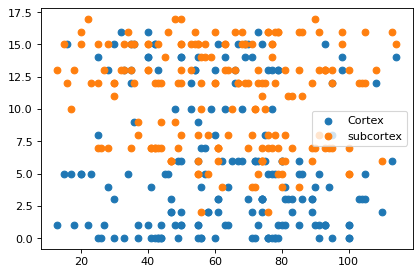

In [306]:
plt.scatter(IQ_seq, N_Cortex_CirSTR_IQ_seq, label="Cortex")
print(spearmanr(IQ_seq, N_Cortex_CirSTR_IQ_seq))
plt.scatter(IQ_seq, N_Subcortex_CirSTR_IQ_seq, label="subcortex")
print(spearmanr(IQ_seq, N_Subcortex_CirSTR_IQ_seq))
plt.legend()

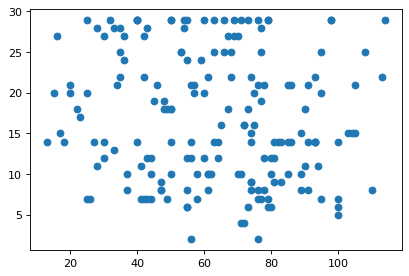

In [292]:
plt.scatter(IQ_seq, N_CirSTR_IQ_seq)

In [284]:
for STR in Circuit_STRs:
    print(STR, HighIQ_STR_Counts[STR], LowIQ_STR_Counts[STR])

Prelimbic_area 23 42
Lateral_amygdalar_nucleus 18 34
Orbital_area_lateral_part 37 57
Nucleus_accumbens 25 45
Dentate_gyrus 32 49
Infralimbic_area 15 41
Orbital_area_ventrolateral_part 20 48
Anterior_olfactory_nucleus 37 33
Anterior_pretectal_nucleus 26 31
Endopiriform_nucleus_dorsal_part 20 42
Claustrum 21 41
Dorsal_peduncular_area 17 39
Basomedial_amygdalar_nucleus 22 25
Field_CA1 21 41
Lateral_posterior_nucleus_of_the_thalamus 31 45
Field_CA3 20 35
Primary_somatosensory_area_lower_limb 23 40
Intercalated_amygdalar_nucleus 38 39
Field_CA2 21 40
Anteromedial_visual_area 17 42
Nucleus_of_reuniens 22 37
Caudoputamen 18 29
Lateral_septal_nucleus_ventral_part 44 40
Parafascicular_nucleus 23 38
Bed_nuclei_of_the_stria_terminalis 31 34
Subiculum_ventral_part 17 37
Endopiriform_nucleus_ventral_part 16 37
Retrosplenial_area_lateral_agranular_part 23 39
Submedial_nucleus_of_the_thalamus 18 33
Primary_visual_area 30 42
Anterior_cingulate_area_dorsal_part 15 38
Visceral_area 25 44
Agranular_insul

# RBS

(38620, 65)
Median 31.000000


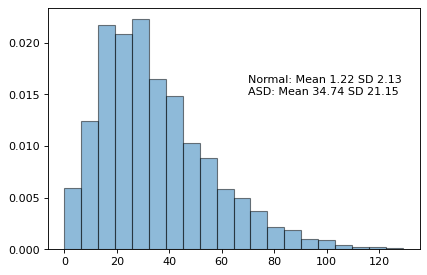

In [348]:
SparkRBSR = pd.read_csv("~/Work/ASD_Phenotype/SPARK_Collection_Version6/rbsr.csv")
SparkRBSR = SparkRBSR.dropna(subset=["total_final_score"])
print(SparkRBSR.shape)
#print(SparkRBSR.columns.values)
print("Median %f"%(np.median(SparkRBSR["total_final_score"].values)))
fig, ax = plt.subplots()
ax.hist(SparkRBSR["total_final_score"], bins=20, density=1, alpha=0.5, edgecolor='black')
ax.text(70, 0.015, s="Normal: Mean 1.22 SD 2.13\nASD: Mean %.2f SD %.2f"%
        (np.mean(SparkRBSR["total_final_score"].values), np.std(SparkRBSR["total_final_score"].values)))
plt.show()

In [352]:
SparkRBSR.head(2)

,subject_sp_id,respondent_sp_id,family_sf_id,biomother_sp_id,biofather_sp_id,sex,asd,depend_adult,age_at_eval_months,age_at_eval_years,...,ii_self_injurious_score,iii_compulsive_behavior_score,iv_ritualistic_behavior_score,v_sameness_behavior_score,vi_restricted_behavior_score,overall_score,overall_number_items,total_final_score,missing_values,eval_year
0,SP0000003,SP0000002,SF0000003,SP0000002,NaN,Male,True,False,136,11,...,11.0,6.0,4.0,24.0,7.0,66,32,66.0,0,2017
1,SP0000013,SP0000010,SF0000013,SP0000010,NaN,Male,True,False,181,15,...,9.0,4.0,7.0,13.0,4.0,39,21,39.0,0,2017


In [349]:
HighRBS = SparkRBSR[SparkRBSR["total_final_score"] >= 31]
LowRBS = SparkRBSR[SparkRBSR["total_final_score"] < 31]
print(HighRBS.shape, LowRBS.shape)

# Select HC genes
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
#Spark_Meta = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1e-3]
HighConfGenes = Spark_Meta_HC["HGNC"].values
HighConfMuts = ASD_Discov_Muts[ASD_Discov_Muts["HGNC"].isin(HighConfGenes)]
#HighConfMuts = ASD_Discov_Muts
HighConfMuts = Filt_LGD_Mis(HighConfMuts, Dmis=True)
#HighConfMuts = HighConfMuts[HighConfMuts["GeneEff"]!="missense"]

# Use All genes

HighRBS_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighRBS["subject_sp_id"].values)]
LowRBS_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowRBS["subject_sp_id"].values)]
print(HighRBS_Muts.shape, LowRBS_Muts.shape)

(19358, 65) (19262, 65)
(82, 44) (124, 44)


In [351]:
HighRBS_Muts.to_csv("dat/Phenotype.HighRBS.csv", index=False)
LowRBS_Muts.to_csv("dat/Phenotype.LowRBs.csv", index=False)

In [353]:
HighConfMuts.to_csv("dat/Phenotype.RBS.muts.csv", index=False)
SparkRBSR.to_csv("dat/Phenotype.Spark.RBS.csv", index=False)

### Bias on sub-population

In [367]:
HRBS_GW = Mut2GeneDF(HighRBS_Muts, 0.347, 0.194) # Not use weights input
HRBS_Spec = AvgSTRZ_Weighted(ExpZ2Mat, HRBS_GW, 
                                 Method = 1, csv_fil = "dat/bias2/ASD.HRBS_spec.bias.csv")

LRBS_GW = Mut2GeneDF(LowRBS_Muts, 0.347, 0.194)
LRBS_Spec = AvgSTRZ_Weighted(ExpZ2Mat, LRBS_GW,
                                 Method = 1, csv_fil = "dat/bias2/ASD.LRBS_spec.bias.csv")

In [368]:
HRBS_Spec = HRBS_Spec.set_index("STR")
LRBS_Spec = LRBS_Spec.set_index("STR")

In [369]:
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Olfactory_areas']
CIR_REGIONS_Dict = {}
for i in range(len(CIR_REGIONS)):
    CIR_REGIONS_Dict[CIR_REGIONS[i]] = []
for _str in Circuit_STRs:
    for i in range(len(CIR_REGIONS)):
        if str2reg[_str] == CIR_REGIONS[i]:
            CIR_REGIONS_Dict[CIR_REGIONS[i]].append(_str)
            break

In [370]:
HighRBS_dat = []
LowRBS_dat = []
#HighIQ_err = []
#LowIQ_err = []
for REG in CIR_REGIONS:
    #xx = GetBootsDist(HIQ_DFs, CIR_REGIONS_Dict[REG])
    #HighIQ_err.append(np.std(xx))
    #xx = GetBootsDist(LIQ_DFs, CIR_REGIONS_Dict[REG])
    #LowIQ_err.append(np.std(xx))
    HighRBS_dat.append(GetBiasDat(HRBS_Spec, CIR_REGIONS_Dict[REG]))
    LowRBS_dat.append(GetBiasDat(LRBS_Spec, CIR_REGIONS_Dict[REG]))

In [359]:
HIQ_DFs = []
#with zipfile.ZipFile("dat/BootStrapMuts/asd.boot.HRBS.zip") as myzip:
#for file in os.listdir("dat/asd.boot.HRBS/"):
for i in range(1,1001,1):
    print(i)
    df = pd.read_csv('dat/asd.boot.HRBS/bootstrap.{}.csv'.format(i), index_col="STR")
    HIQ_DFs.append(df)
LIQ_DFs = []
#for file in os.listdir("dat/asd.boot.LRBS/"):
for i in range(1,1001,1):
    print(i)
    df = pd.read_csv('dat/asd.boot.LRBS/bootstrap.{}.csv'.format(i), index_col="STR")
    LIQ_DFs.append(df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [363]:
HighIQ_dat = []
LowIQ_dat = []
HighIQ_err = []
LowIQ_err = []
for REG in CIR_REGIONS:
    if REG in ["Midbrain", "Pallidum"]:
        continue
    xx = GetBootsDist(HIQ_DFs, CIR_REGIONS_Dict[REG])
    HighIQ_err.append(np.std(xx))
    xx = GetBootsDist(LIQ_DFs, CIR_REGIONS_Dict[REG])
    LowIQ_err.append(np.std(xx))
    HighIQ_dat.append(GetBiasDat(HIQ_Spec, CIR_REGIONS_Dict[REG]))
    LowIQ_dat.append(GetBiasDat(LIQ_Spec, CIR_REGIONS_Dict[REG]))

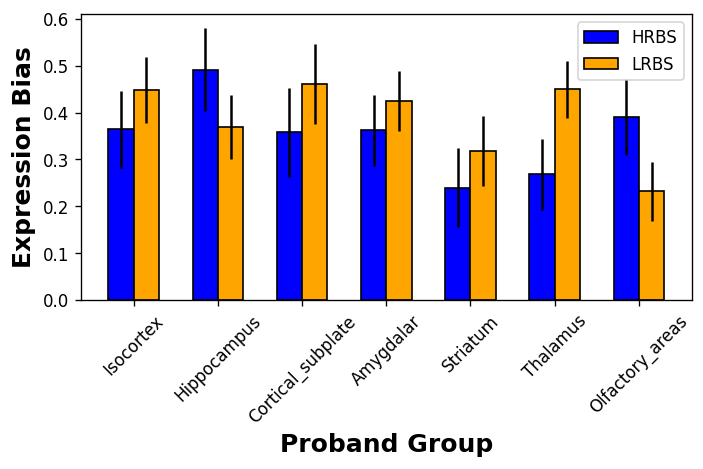

In [383]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))

#ax.bar(X - 0.15, HighRBS_dat, color='blue', width=0.3, label="HRBS", 
#       edgecolor ='black')
#ax.bar(X + 0.15, LowRBS_dat, color='orange', width=0.3, label="LRBS", 
#   edgecolor ='black')

ax.bar(X - 0.15, HighRBS_dat, yerr=HighIQ_err, color="blue", width=0.3, label="HRBS", 
       edgecolor ='black')
ax.bar(X + 0.15, LowRBS_dat, yerr=LowIQ_err, color="orange", width=0.3, label="LRBS", 
   edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.tight_layout()
#pdf.savefig( fig )
plt.savefig("figs/Phenotype_RBS_STR_Bias.pdf")

In [375]:
XXX = {"HighIQ":[], "LowIQ":[]}
for i in range(1, 1001):
    df1 = pd.read_csv("dat/RBS_permut/HighRBS_spec.bias.perm.{}.csv".format(i), index_col="STR")
    df2 = pd.read_csv("dat/RBS_permut/LowRBS_spec.bias.perm.{}.csv".format(i), index_col="STR")
    XXX["HighIQ"].append(df1)
    XXX["LowIQ"].append(df2)

In [377]:
Region_Dat = {}
for Region in CIR_REGIONS_Dict.keys():
    STRs = CIR_REGIONS_Dict[Region]
    #print(Region, STRs)
    Region_Avg_Bias_Dat = []
    for i in range(1000):
        df1 = XXX["HighIQ"][i]
        df2 = XXX["LowIQ"][i]
        HIQ_Region_bias = df1.loc[STRs, "EFFECT"].mean()
        LIQ_Region_bias = df2.loc[STRs, "EFFECT"].mean()
        Diff = HIQ_Region_bias - LIQ_Region_bias
        Region_Avg_Bias_Dat.append([HIQ_Region_bias, LIQ_Region_bias, Diff])
    Region_Dat[Region] = np.array(Region_Avg_Bias_Dat)
    
#Format: HIQ_Region_bias, LIQ_Region_bias, Diff as columns, diff permutations as rows

In [382]:
#HighIQ_Spec
#LowIQ_Spec
for Region in CIR_REGIONS_Dict.keys():
    STRs = CIR_REGIONS_Dict[Region]
    print(Region, Region_Dat[Region][:, 0].mean(), Region_Dat[Region][:, 1].mean(), 
          Region_Dat[Region][:, 2].mean())
    HIQ_Region_bias = HRBS_Spec.loc[STRs, "EFFECT"].mean()
    LIQ_Region_bias = LRBS_Spec.loc[STRs, "EFFECT"].mean()
    permut_diff = Region_Dat[Region][:, 2]
    Diff = HIQ_Region_bias - LIQ_Region_bias
    Z, P = GetPermutationP(permut_diff, Diff, gt=False)
    print(np.mean(permut_diff), Diff, P)
    print()
    #fig, ax = plt.subplots()
    #ax.hist(Region_Dat[Region][:, 0], color="blue", label="HIQ")
    #ax.hist(Region_Dat[Region][:, 1], color="red", label="LIQ")
    #plt.show()

Isocortex 0.4048396810977647 0.40302185141620356 0.0018178296815611686
0.0018178296815611686 -0.08350565488819506 0.22177822177822182

Hippocampus 0.4089845774361909 0.4107753592105246 -0.0017907817743337273
-0.0017907817743337273 0.12210309718145329 0.8621378621378621

Cortical_subplate 0.41146174708479794 0.41595541383028406 -0.004493666745486127
-0.004493666745486127 -0.10267229940363709 0.19480519480519476

Amygdalar 0.3996483656665081 0.4030584189903384 -0.0034100533238302613
-0.0034100533238302613 -0.06249109966698235 0.2697302697302697

Striatum 0.26625029597965816 0.2638231849273635 0.00242711105229467
0.00242711105229467 -0.07821338940991501 0.2407592407592407

Thalamus 0.3793652926973024 0.3806021026906244 -0.0012368099933220903
-0.0012368099933220903 -0.1813081347479989 0.025974025974025983

Olfactory_areas 0.27403698047530733 0.2759083842737979 -0.0018714037984905304
-0.0018714037984905304 0.15820877107776546 0.9430569430569431



In [384]:
def hahahaha(STR, XXX):
    res = []
    for i in range(0, 1000):
        #print(i, len(XXX["HighIQ"]))
        df1 = XXX["HighIQ"][i]
        df2 = XXX["LowIQ"][i]
        effect_diff = df2.loc[STR, "EFFECT"] - df1.loc[STR, "EFFECT"]
        res.append(effect_diff)
    return np.array(res)

In [385]:
str2reg = STR2Region()
IQ_Phenotype_dat = []
for STR in Circuit_STRs:
    Region = str2reg[STR]
    A_effect = HRBS_Spec.loc[STR, "EFFECT"]
    B_effect = LRBS_Spec.loc[STR, "EFFECT"]
    A_rank = HRBS_Spec.loc[STR, "Rank"]
    B_rank = LRBS_Spec.loc[STR, "Rank"]
    BiasDiff = B_effect - A_effect
    RankDiff = B_rank - A_rank
    IQ_Phenotype_dat.append([STR, Region, A_effect, B_effect, 
                             A_rank, B_rank, BiasDiff, RankDiff])
RBS_PhenotypeDF = pd.DataFrame(IQ_Phenotype_dat, columns=["STR", "REG", "HighIQ Bias", 
            "LowIQ Bias", "HighIQ Rank", "LowIQ Rank", "Bias Diff (low-high)", "Rank Diff"])
RBS_PhenotypeDF.to_csv("dat/IQ_Bias_Diff.csv", index=False)

In [387]:
DataDF_dat = []
for i, row in RBS_PhenotypeDF.iterrows():
    STR = row["STR"]
    REG = row["REG"]
    Diff = row["Bias Diff (low-high)"]
    HighIQ = row["HighIQ Bias"]
    LowIQ = row["LowIQ Bias"]
    permut_diff = hahahaha(STR, XXX)
    Z, P = GetPermutationP(permut_diff, Diff, gt=True)
    IQ_PhenotypeDF.loc[i, "Pvalue"] = P
    print("%s %.3f %.3f %.3f %.3e" % (STR, HighIQ, LowIQ, Diff, P))

Lateral_amygdalar_nucleus 0.508 0.597 0.089 3.197e-01
Orbital_area_lateral_part 0.519 0.507 -0.012 5.395e-01
Prelimbic_area 0.575 0.570 -0.005 5.175e-01
Dentate_gyrus 0.765 0.348 -0.417 9.960e-01
Nucleus_accumbens 0.373 0.396 0.023 4.246e-01
Orbital_area_ventrolateral_part 0.470 0.478 0.007 4.815e-01
Anterior_pretectal_nucleus 0.413 0.405 -0.008 5.195e-01
Basomedial_amygdalar_nucleus 0.455 0.483 0.028 4.156e-01
Lateral_posterior_nucleus_of_the_thalamus 0.404 0.349 -0.055 6.224e-01
Infralimbic_area 0.457 0.463 0.006 4.925e-01
Intercalated_amygdalar_nucleus 0.353 0.339 -0.014 5.684e-01
Endopiriform_nucleus_dorsal_part 0.370 0.435 0.066 3.197e-01
Claustrum 0.412 0.493 0.081 2.717e-01
Nucleus_of_reuniens 0.400 0.422 0.022 4.386e-01
Anterior_olfactory_nucleus 0.584 0.222 -0.362 9.970e-01
Primary_somatosensory_area_lower_limb 0.425 0.526 0.100 2.068e-01
Dorsal_peduncular_area 0.383 0.412 0.029 4.386e-01
Field_CA3 0.572 0.385 -0.187 8.811e-01
Subiculum_ventral_part 0.300 0.479 0.180 1.239e-01

In [ ]:
#HighIQ_Spec
#LowIQ_Spec
for Region in CIR_REGIONS_Dict.keys():
    STRs = CIR_REGIONS_Dict[Region]
    print(Region, Region_Dat[Region][:, 0].mean(), Region_Dat[Region][:, 1].mean(), 
          Region_Dat[Region][:, 2].mean())
    HIQ_Region_bias = HighIQ_Spec.loc[STRs, "EFFECT"].mean()
    LIQ_Region_bias = LowIQ_Spec.loc[STRs, "EFFECT"].mean()
    permut_diff = Region_Dat[Region][:, 2]
    Diff = HIQ_Region_bias - LIQ_Region_bias
    Z, P = GetPermutationP(permut_diff, Diff, gt=False)
    print(np.mean(permut_diff), Diff, P)
    
    fig, ax = plt.subplots()
    ax.hist(Region_Dat[Region][:, 0], color="blue", label="HIQ")
    ax.hist(Region_Dat[Region][:, 1], color="red", label="LIQ")
    plt.show()

In [551]:
RBS_Phenotype_dat = []
for STR in Circuit_STRs:
    Region = str2reg[STR]
    A_effect = HRBS_Spec.loc[STR, "EFFECT"]
    B_effect = LRBS_Spec.loc[STR, "EFFECT"]
    A_rank = HRBS_Spec.loc[STR, "Rank"]
    B_rank = LRBS_Spec.loc[STR, "Rank"]
    BiasDiff = B_effect - A_effect
    RankDiff = B_rank - A_rank
    RBS_Phenotype_dat.append([STR, Region, A_effect, B_effect, 
                             A_rank, B_rank, BiasDiff, RankDiff])
RBS_PhenotypeDF = pd.DataFrame(RBS_Phenotype_dat, columns=["STR", "REG", "HighRBS Bias", 
            "LowRBS Bias", "HighRBS Rank", "LowRBS Rank", "Bias Diff (low-high)", "Rank Diff"])
RBS_PhenotypeDF.to_csv("dat/RBS_Bias_Diff.csv", index=False)

In [552]:
writer = pd.ExcelWriter('dat/RBS_Bias.xlsx', engine='xlsxwriter')
RBS_PhenotypeDF.to_excel(writer, sheet_name='RBS_Bias_Circuits')
HRBS_Spec.to_excel(writer, sheet_name='HighIQ_Spec')
LRBS_Spec.to_excel(writer, sheet_name='LowIQ_Spec')
writer.save()

In [600]:
print(len( set(HRBS_Spec.head(50).index.values).intersection(
    set(LRBS_Spec.head(50).index.values)) ))

35


-0.06336648062342214 0.6619840342032234 0.022136854741896757 0.8787210618032604


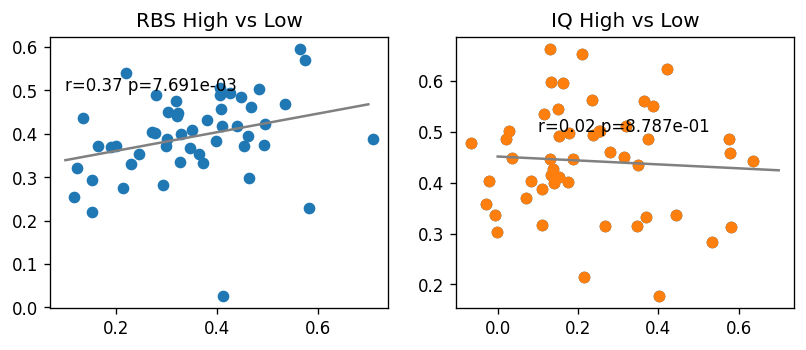

In [609]:
fig, (ax1, ax2) = plt.subplots(1,2, dpi=120, figsize=(8,3))
X = RBS_PhenotypeDF["HighRBS Bias"].values
Y = RBS_PhenotypeDF["LowRBS Bias"].values
lm = sm.OLS(Y,sm.add_constant(X)).fit()
X_plot = np.array([0.1, 0.7])
ax1.plot(X_plot, X_plot*lm.params[1] + lm.params[0], color="grey")
#plt.text(0.1, 0.5, s="coef=%.2f P=%.3e"%(lm.params[1], lm.pvalues[1]))
r, p = pearsonr(X,Y)
rho, p_rho = spearmanr(X,Y)
ax1.text(0.1, 0.5, s="r=%.2f p=%.3e"%(rho, p_rho))
ax1.scatter(X,Y)
ax1.set_title("RBS High vs Low")

X = IQ_PhenotypeDF["HighIQ Bias"].values
Y = IQ_PhenotypeDF["LowIQ Bias"].values
lm = sm.OLS(Y,sm.add_constant(X)).fit()
X_plot = np.array([0.0, 0.7])
ax2.plot(X_plot, X_plot*lm.params[1] + lm.params[0], color="grey")
r, p = pearsonr(X,Y)

rho, p_rho = spearmanr(X,Y)
ax2.text(0.1, 0.5, s="r=%.2f p=%.3e"%(rho, p_rho))
ax2.scatter(X,Y)
ax2.scatter(X,Y)
ax2.set_title("IQ High vs Low")
plt.savefig("figs/Phenotype_RBS_IQ_correlation.pdf")

In [608]:
print(len( set(HighIQ_Spec.head(50).index.values).intersection(
    set(LowIQ_Spec.head(50).index.values)) ))

19


In [606]:
HighIQ_Spec

,EFFECT,REGION,Rank
STR,,,
Anterior_pretectal_nucleus,0.636909,Midbrain,1
Accessory_olfactory_bulb,0.581818,Olfactory_areas,2
Anterior_olfactory_nucleus,0.578369,Olfactory_areas,3
Lateral_septal_nucleus_ventral_part,0.576520,Striatum,4
Intercalated_amygdalar_nucleus,0.534196,Amygdalar,5
...,...,...,...
Medullary_reticular_nucleus_ventral_part,-0.551383,Medulla,209
Primary_auditory_area,-0.563877,Isocortex,210
Magnocellular_reticular_nucleus,-0.589455,Medulla,211


In [607]:
LowIQ_Spec

,EFFECT,REGION,Rank
STR,,,
Lateral_amygdalar_nucleus,0.662807,Amygdalar,1
Prelimbic_area,0.653488,Isocortex,2
Dentate_gyrus,0.622575,Hippocampus,3
Infralimbic_area,0.597998,Isocortex,4
Field_CA1,0.596485,Hippocampus,5
...,...,...,...
Intermediate_reticular_nucleus,-0.830554,Medulla,209
Lateral_reticular_nucleus,-0.832421,Medulla,210
Paragigantocellular_reticular_nucleus_lateral_part,-0.848677,Medulla,211
